# Probing GCN

### Dataset 
Here we'll first be loading the FC matrices and explore their structure

In [2]:
#using read_dataset from Datasets/FC/create_dataset.py to read the dataset
from Datasets.FC.create_dataset import read_dataset
import torch 
print('GPU available?', torch.cuda.is_available())

GPU available? False


In [3]:
dataset = read_dataset()

In [4]:
#ok, let's explore the data a bit more
#dataset is a list object of torch_geometric.data objects

#let's see the first element
print(dataset[0])

#it's a dictionary object, let's see the keys
print(dataset[0].keys())

#ok, let's see the values
print(dataset[0].values())

#it has 4 keys, 'x', 'edge_index', 'edge_attr' and 'y' where y=0 menas the patient is healthy and y=1 means the patient has Autism Spectrum Disorder (ASD)
"""graph = Data(x=ROI.reshape(-1,116).float(),
                     edge_index=G.indices().reshape(2,-1).long(),
                     edge_attr=G.values().reshape(-1,1).float(),
                     y=y.long())"""

#how much data do we have?
len(dataset)


Data(x=[116, 116], edge_index=[2, 1016], edge_attr=[1016, 1], y=[1])
['edge_attr', 'y', 'x', 'edge_index']
ValuesView({'x': tensor([[ 0.0000,  0.4543,  0.2477,  ...,  0.1753,  0.2247, -0.1751],
        [ 0.4543,  0.0000, -0.2204,  ..., -0.1947, -0.2258, -0.1434],
        [ 0.2477, -0.2204,  0.0000,  ..., -0.0521, -0.0804, -0.2025],
        ...,
        [ 0.1753, -0.1947, -0.0521,  ...,  0.0000,  0.6875, -0.1364],
        [ 0.2247, -0.2258, -0.0804,  ...,  0.6875,  0.0000,  0.0929],
        [-0.1751, -0.1434, -0.2025,  ..., -0.1364,  0.0929,  0.0000]]), 'edge_index': tensor([[  0,   0,   0,  ..., 114, 115, 115],
        [  1,  10,  12,  ..., 113,  94, 109]]), 'edge_attr': tensor([[0.4543],
        [0.5913],
        [0.4224],
        ...,
        [0.6875],
        [0.4846],
        [0.5437]]), 'y': tensor([0])})


1099

### Model 
Loading the model

In [5]:
#set the seed
import torch
torch.manual_seed(37)

MODEL = "GCN_wo_edge_weight"
DATASET = "FC"

from models.models_FC import GCN_framework_wo_edge_weight as framework # import the model

gnn = framework(dataset)

print(gnn.model)
print(gnn.train_idx)

Net(
  (conv_layers): ModuleList(
    (0): GCNConv(116, 128)
    (1-4): 4 x GCNConv(128, 128)
  )
  (batch_norms): ModuleList(
    (0-4): 5 x BatchNorm(128)
  )
  (lin1): Linear(128, 128, bias=True)
  (lin2): Linear(128, 2, bias=True)
  (bn1): BatchNorm(128)
  (bn2): BatchNorm(2)
)
tensor([217, 137, 426,  ..., 643, 205, 434])


c:\Users\tomdu\miniconda3\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [6]:
# gnn.iterate()

In [7]:
#gnn.train()

In [7]:
#save the model 
# gnn.save_model(path="models/"+DATASET+"_"+MODEL+"server.pt")

In [8]:
#load the model
gnn.load_model(path="models/"+DATASET+"_"+MODEL+"server.pt")

In [9]:
gnn.evaluate()

Test Loss: 0.728, Train Acc: 1.000 Test Acc: 0.564


### Properties

In [19]:
import pickle as pkl
import networkx as nx

def calculate_avg_path_length(G):
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    else:
        # Alternative metrics for disconnected graphs
        # Option 1: Use the average path length of the largest connected component
        components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
        largest_component = max(components, key=len)
        return nx.average_shortest_path_length(largest_component)
    
def calculate_small_world(G):
    if nx.is_connected(G):
        return nx.algorithms.smallworld.sigma(G)
    else:
        # Alternative metrics for disconnected graphs
        # Option 1: Use the small world coefficient of the largest connected component
        components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
        largest_component = max(components, key=len)
        return nx.algorithms.smallworld.sigma(largest_component)
    
def compute_swi(graph):
    # Calculate clustering coefficient and average path length for the given graph
    clustering_coeff = nx.average_clustering(graph)
    avg_path_len = calculate_avg_path_length(graph)
    
    # Generate a random graph with the same number of nodes and edges
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    random_graph = nx.gnm_random_graph(num_nodes, num_edges)
    
    # Generate a lattice graph with the same number of nodes and edges
    lattice_graph = nx.watts_strogatz_graph(num_nodes, k=4, p=0)  # Adjust k as needed
    
    # Calculate clustering coefficient and average path length for the random graph
    random_clustering_coeff = nx.average_clustering(random_graph)
    random_avg_path_len = calculate_avg_path_length(random_graph)
    
    # Calculate clustering coefficient and average path length for the lattice graph
    lattice_clustering_coeff = nx.average_clustering(lattice_graph)
    lattice_avg_path_len = calculate_avg_path_length(lattice_graph)
    
    # Compute the Small-World Index (SWI)
    swi = ((avg_path_len - lattice_avg_path_len) / (random_avg_path_len - lattice_avg_path_len)) * \
          ((clustering_coeff - random_clustering_coeff) / (lattice_clustering_coeff - random_clustering_coeff))
    
    return swi
    

def compute_graph_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        num_nodes = G.number_of_nodes()
        num_edges = G.number_of_edges()
        density = nx.density(G)
        avg_path_len = calculate_avg_path_length(G)
        num_cliques = len(list(nx.find_cliques(G)))
        num_triangles = sum(nx.triangles(G).values()) / 3
        num_squares = sum(nx.square_clustering(G).values()) / 4
        number_of_node_in_the_largest_fully_connected_component = len(max(nx.connected_components(G), key=len))
        assortativity = nx.degree_assortativity_coefficient(G)
        small_world = compute_swi(G)
            
        properties.append((num_nodes, num_edges, density, avg_path_len, num_cliques, num_triangles, num_squares, number_of_node_in_the_largest_fully_connected_component, assortativity, small_world))
    return properties

train_idx_list = gnn.train_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in train_idx_list]
train_properties = compute_graph_properties(selected_dataset)
test_idx_list = gnn.test_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in test_idx_list]
test_properties = compute_graph_properties(selected_dataset)

# Save the properties to files
with open("results/"+DATASET+"_"+MODEL+"_train_properties_with_sm.pkl", "wb") as f:
    pkl.dump(train_properties, f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_with_sm.pkl", "wb") as f:
    pkl.dump(test_properties, f)

In [20]:
# print(len(train_properties))
# train_properties[0:5]



In [22]:
import pickle as pkl
#save the properties in a file
# with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "wb") as f:
#     pkl.dump(train_properties, f)

# with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "wb") as f:
#     pkl.dump(test_properties, f)

#load the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties_with_sm.pkl", "rb") as f:
    train_properties = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_with_sm.pkl", "rb") as f:
    test_properties = pkl.load(f)

In [11]:
train_properties

[(116,
  717,
  0.10749625187406296,
  2.6724137931034484,
  263,
  1735.0,
  6.64946643069199,
  116,
  0.3963636188813396,
  1.0003607038785656),
 (116,
  473,
  0.07091454272863568,
  3.4743628185907047,
  158,
  708.0,
  7.095858020333574,
  116,
  0.28679287295765565,
  0.9389416214401753),
 (116,
  997,
  0.1494752623688156,
  2.469265367316342,
  343,
  3591.0,
  7.864813698203321,
  116,
  0.45675805097082345,
  1.0693818900924983),
 (116,
  892,
  0.13373313343328336,
  2.874662668665667,
  144,
  3409.0,
  10.613595627764592,
  116,
  0.5039099001590127,
  1.327100875670131),
 (116,
  504,
  0.07556221889055473,
  3.1734202763546033,
  155,
  861.0,
  6.351955841015705,
  114,
  0.3455129203218888,
  0.9282822477123186),
 (116,
  442,
  0.06626686656671664,
  3.6082458770614694,
  147,
  754.0,
  6.164051723419249,
  116,
  0.5552921382826579,
  0.8726738593097689),
 (115,
  600,
  0.09153318077803203,
  4.506636155606407,
  103,
  2162.0,
  10.325440232309345,
  115,
  0.795

### Features

Concretely, train and test features are lists that correspond to graphs. train is for the train graphs and test for the test graphs. So for example, train_features is a list of length 1044. For each graph, we have a list of embeddings. These embeddings correspond to the 7 or 8 different layers in our GNN. So for exemple if we want to access the embedding of the 3rd layer for our graph number 37 in the train set, we would do train_features[37][2]. If the batch size if put to 1, we should have access for the layers before the max or mean_pooling, to a matrix of shape (number_of_nodes, number_of_features), so for exemple for our same graph and same layer we would have a feature matrix of shape (116, 128). Then starting with the max_pooling layer we should have represntation of the whole graph and a vector embedding of shape (,128). 

In [19]:
train_features, test_features = gnn.evaluate_with_features2()
# train_features, test_features = gnn.evaluate_with_features2(return_node_embeddings=True)

In [13]:
print(len(train_features[0]))
len(train_features), len(test_features)

8


(1044, 55)

In [23]:
"""
The embeddings of GCN are like this:
return F.log_softmax(x7, dim=-1), (x1, x2, x3, x4, x5, x_global, x6, x7)
"""


import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
output_size = 1  # Predicting one property at a time
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Assume we have already evaluated to get features
#train_features, test_features = gnn.evaluate_with_features2()

# Extract x embeddings
train_x = np.array([feat[0] for feat in train_features])
test_x = np.array([feat[0] for feat in test_features])

# Extract 2, 3, 4, global, 5, 6, 7 embeddings
train_x2 = np.array([feat[1] for feat in train_features])
test_x2 = np.array([feat[1] for feat in test_features])

train_x3 = np.array([feat[2] for feat in train_features])
test_x3 = np.array([feat[2] for feat in test_features])

train_x4 = np.array([feat[3] for feat in train_features])
test_x4 = np.array([feat[3] for feat in test_features])

train_x5 = np.array([feat[4] for feat in train_features])
test_x5 = np.array([feat[4] for feat in test_features])

train_x_global = np.array([feat[5] for feat in train_features])
test_x_global = np.array([feat[5] for feat in test_features])

train_x6 = np.array([feat[6] for feat in train_features])
test_x6 = np.array([feat[6] for feat in test_features])

train_x7 = np.array([feat[7] for feat in train_features])
test_x7 = np.array([feat[7] for feat in test_features])

# Compute graph properties
# train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
# test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_x2 = torch.tensor(train_x2, dtype=torch.float32)
train_x3 = torch.tensor(train_x3, dtype=torch.float32)
train_x4 = torch.tensor(train_x4, dtype=torch.float32)
train_x5 = torch.tensor(train_x5, dtype=torch.float32)
train_x_global = torch.tensor(train_x_global, dtype=torch.float32)
train_x6 = torch.tensor(train_x6, dtype=torch.float32)
train_x7 = torch.tensor(train_x7, dtype=torch.float32)

test_x = torch.tensor(test_x, dtype=torch.float32)
test_x2 = torch.tensor(test_x2, dtype=torch.float32)
test_x3 = torch.tensor(test_x3, dtype=torch.float32)
test_x4 = torch.tensor(test_x4, dtype=torch.float32)
test_x5 = torch.tensor(test_x5, dtype=torch.float32)
test_x_global = torch.tensor(test_x_global, dtype=torch.float32)
test_x6 = torch.tensor(test_x6, dtype=torch.float32)
test_x7 = torch.tensor(test_x7, dtype=torch.float32)

train_y = torch.tensor(train_properties, dtype=torch.float32)
test_y = torch.tensor(test_properties, dtype=torch.float32)

# Train and evaluate a model for each graph property and each embedding
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component','assortativity', 'small_world']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x5, test_x5), (train_x_global, test_x_global), (train_x6, test_x6), (train_x7, test_x7)]
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']

In [15]:
print(train_x2.shape)
print(train_x6.shape)

torch.Size([1044, 116, 128])
torch.Size([1044, 1, 128])


### Diagnostic classifier

Linear classifiers need flatten inputs and these can't be multi-dimensional. Our embeddings have the shape of `(number_of_nodes, number_of_features)` before the max_pooling and of shape `(1, number_of_features)` after the max_pooling.


In [37]:
"""
Classifier for the embeddings with return_node_embeddings=True
"""
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pickle as pkl

#create a dictionary where we will store the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    # Flatten the embeddings before determining the input size
    train_embedding_flat = train_embedding.view(train_embedding.size(0), -1)
    test_embedding_flat = test_embedding.view(test_embedding.size(0), -1)
    #print the shapes
    print(train_embedding_flat.shape)
    print(test_embedding_flat.shape)
    input_size = train_embedding_flat.shape[1]

    for i, property_name in enumerate(property_names):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 2000000  # Maximum number of epochs
        min_epochs = 1000  # Minimum number of epochs
        patience = 3000  # Number of epochs to wait for improvement
        tolerance = 1e-6  # Tolerance for considering the loss as stable

        best_loss = float('inf')
        no_improve_count = 0
        
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding_flat).squeeze()
            target = train_y[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Print every 1000 epochs
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

            # Check for early stopping, but only after minimum epochs
            if epoch >= min_epochs:
                if loss.item() < best_loss - tolerance:
                    best_loss = loss.item()
                    no_improve_count = 0
                else:
                    no_improve_count += 1

                if no_improve_count >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding_flat).squeeze().cpu().numpy()
            test_pred = model(test_embedding_flat).squeeze().cpu().numpy()

            train_target = train_y[:, i].cpu().numpy()
            test_target = test_y[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embedding = embeddings_names[ii]
            results[(name_of_embedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_full_embedding.pkl", "wb") as f:
    pkl.dump(results, f)

torch.Size([1044, 14848])
torch.Size([55, 14848])
Epoch [1000/1300000], Property: num_nodes, Loss: 1.5060
Epoch [2000/1300000], Property: num_nodes, Loss: 0.0582
Epoch [3000/1300000], Property: num_nodes, Loss: 0.0008
Epoch [4000/1300000], Property: num_nodes, Loss: 0.0000
Epoch [5000/1300000], Property: num_nodes, Loss: 0.0000
Epoch [6000/1300000], Property: num_nodes, Loss: 0.0000
Epoch [7000/1300000], Property: num_nodes, Loss: 0.0000
Early stopping at epoch 7170
Embedding: torch.Size([1044, 116, 128])
Property: num_nodes
  Train MSE: 0.0000, Test MSE: 39.0101
  Train R²: 1.0000, Test R²: -43.2964
Epoch [1000/1300000], Property: num_edges, Loss: 1551.7554
Epoch [2000/1300000], Property: num_edges, Loss: 583.6703
Epoch [3000/1300000], Property: num_edges, Loss: 231.4195
Epoch [4000/1300000], Property: num_edges, Loss: 76.1155
Epoch [5000/1300000], Property: num_edges, Loss: 17.7620
Epoch [6000/1300000], Property: num_edges, Loss: 2.3828
Epoch [7000/1300000], Property: num_edges, Loss

In [16]:
#load results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_full_embedding.pkl", "rb") as f:
    results = pkl.load(f)

### Plots

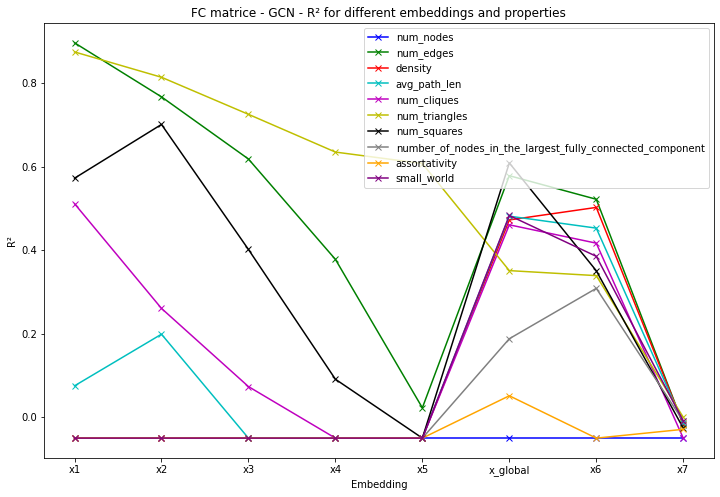

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component','assortativity', 'small_world']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'grey', 'orange', 'purple']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_name)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+"_"+MODEL+'_test_R2_plot_limited_cv_full_embedding_full_embedding.png', dpi=300, bbox_inches='tight')

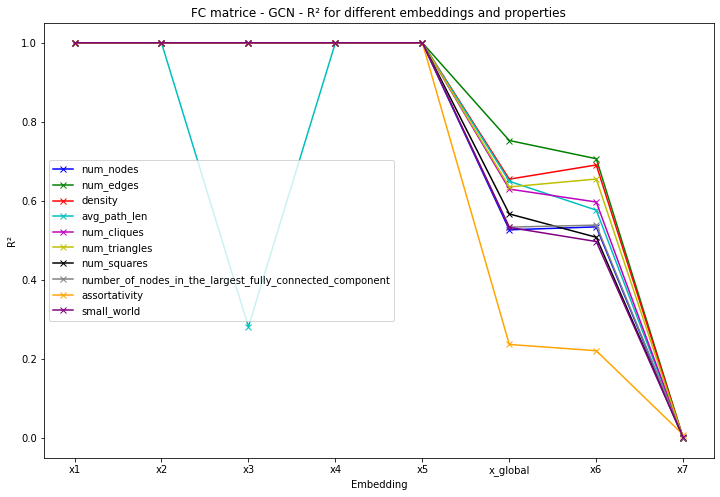

<Figure size 432x288 with 0 Axes>

In [18]:
# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component','assortativity', 'small_world']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'grey', 'orange', 'purple']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        train_r2 = results[(name_of_embedding, property_name)][2]
        if train_r2 < -0.05:  # Handle negative R² values
            train_r2 = -0.05
        x_points.append(j)
        y_points.append(train_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+"_"+MODEL+'_train_R2_plot_limited_cv_full_embedding.png', dpi=300, bbox_inches='tight')

# Test with more properties

### Properties

In [19]:
import networkx as nx
import numpy as np

def calculate_avg_path_length(G):
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    else:
        # Use the average path length of the largest connected component for disconnected graphs
        components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
        largest_component = max(components, key=len)
        return nx.average_shortest_path_length(largest_component)
    
   
def compute_swi(graph):
    # Calculate clustering coefficient and average path length for the given graph
    clustering_coeff = nx.average_clustering(graph)
    avg_path_len = calculate_avg_path_length(graph)
    
    # Generate a random graph with the same number of nodes and edges
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    random_graph = nx.gnm_random_graph(num_nodes, num_edges)
    
    # Generate a lattice graph with the same number of nodes and edges
    lattice_graph = nx.watts_strogatz_graph(num_nodes, k=4, p=0)  # Adjust k as needed
    
    # Calculate clustering coefficient and average path length for the random graph
    random_clustering_coeff = nx.average_clustering(random_graph)
    random_avg_path_len = calculate_avg_path_length(random_graph)
    
    # Calculate clustering coefficient and average path length for the lattice graph
    lattice_clustering_coeff = nx.average_clustering(lattice_graph)
    lattice_avg_path_len = calculate_avg_path_length(lattice_graph)
    
    # Compute the Small-World Index (SWI)
    swi = ((avg_path_len - lattice_avg_path_len) / (random_avg_path_len - lattice_avg_path_len)) * \
          ((clustering_coeff - random_clustering_coeff) / (lattice_clustering_coeff - random_clustering_coeff))
    
    return swi


def betweenness_centralization(G):
    n = len(G)
    betweenness = nx.betweenness_centrality(G)
    max_betweenness = max(betweenness.values())
    centralization = sum(max_betweenness - bet for bet in betweenness.values())
    if n > 2:
        centralization /= (n - 1) * (n - 2) / 2
    return centralization

def pagerank_centralization(G, alpha=0.85):
    n = len(G)
    pagerank = nx.pagerank(G, alpha=alpha)
    max_pagerank = max(pagerank.values())
    centralization = sum(max_pagerank - pr for pr in pagerank.values())
    if n > 1:
        centralization /= (n - 1)
    return centralization

def clustering_properties(G):
    average_clustering = nx.average_clustering(G)
    transitivity = nx.transitivity(G)
    return average_clustering, transitivity

def compute_graph_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        
        # Number of nodes
        num_nodes = G.number_of_nodes()
        
        # Number of edges
        num_edges = G.number_of_edges()
        
        # Density
        density = nx.density(G)
        
        # Average Path Length
        avg_path_len = calculate_avg_path_length(G)
        
        # Diameter
        if nx.is_connected(G):
            diameter = nx.diameter(G)
        else:
            # Use the diameter of the largest connected component for disconnected graphs
            components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
            largest_component = max(components, key=len)
            diameter = nx.diameter(largest_component)
        
        # Radius
        if nx.is_connected(G):
            radius = nx.radius(G)
        else:
            radius = nx.radius(largest_component)
        
        # Clustering Coefficient
        clustering_coeff = nx.average_clustering(G)
        
        # Transitivity
        transitivity = nx.transitivity(G)
        
        # Assortativity
        assortativity = nx.degree_assortativity_coefficient(G)
        
        # Number of Cliques
        num_cliques = len(list(nx.find_cliques(G)))
        
        # Number of Triangles
        num_triangles = sum(nx.triangles(G).values()) / 3
        
        # Number of Squares (4-cycles)
        num_squares = sum(nx.square_clustering(G).values()) / 4
        
        # Size of the Largest Connected Component
        largest_component_size = len(max(nx.connected_components(G), key=len))
        
        # Average Degree
        degrees = [d for n, d in G.degree()]
        avg_degree = np.mean(degrees)
        
        # Betweenness Centrality
        betweenness_centrality = nx.betweenness_centrality(G)
        avg_betweenness_centrality = np.mean(list(betweenness_centrality.values()))
        
        # Eigenvalues of the Adjacency Matrix (for spectral properties)
        eigenvalues = np.linalg.eigvals(nx.adjacency_matrix(G).todense())
        spectral_radius = max(eigenvalues)
        algebraic_connectivity = sorted(eigenvalues)[1]  # second smallest eigenvalue
        
        # Graph Laplacian Eigenvalues
        laplacian_eigenvalues = np.linalg.eigvals(nx.laplacian_matrix(G).todense())
        graph_energy = sum(abs(laplacian_eigenvalues))
        
        # Small-World-ness
        # Compare clustering coefficient and average path length with those of a random graph
        random_graph = nx.gnm_random_graph(num_nodes, num_edges)
        random_clustering_coeff = nx.average_clustering(random_graph)
        random_avg_path_len = calculate_avg_path_length(random_graph)
        small_world_coefficient = (clustering_coeff / random_clustering_coeff) / (avg_path_len / random_avg_path_len)

        small_world_index = compute_swi(G)

        # Calculate Betweenness Centralization
        betweenness_cent = betweenness_centralization(G)
        print(f"Betweenness Centralization: {betweenness_cent}")

        # Calculate PageRank Centralization
        pagerank_cent = pagerank_centralization(G)
        print(f"PageRank Centralization: {pagerank_cent}")

        # Calculate Clustering properties
        avg_clustering, transitivity = clustering_properties(G)
        print(f"Average Clustering Coefficient: {avg_clustering}")
        print(f"Transitivity: {transitivity}")
        
        properties.append((
            num_nodes,
            num_edges,
            density,
            avg_path_len,
            diameter,
            radius,
            clustering_coeff,
            transitivity,
            assortativity,
            num_cliques,
            num_triangles,
            num_squares,
            largest_component_size,
            avg_degree,
            avg_betweenness_centrality,
            spectral_radius,
            algebraic_connectivity,
            graph_energy,
            small_world_coefficient, 
            betweenness_cent,
            pagerank_cent,
            avg_clustering,
            small_world_index           

        ))
    return properties





In [20]:

train_idx_list = gnn.train_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in train_idx_list]
train_properties_long = compute_graph_properties(selected_dataset)
test_idx_list = gnn.test_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in test_idx_list]
test_properties_long = compute_graph_properties(selected_dataset)

#save the properties in a file
with open("results/"+DATASET+"_"+MODEL+"_train_properties_long.pkl", "wb") as f:
    pkl.dump(train_properties_long, f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_long.pkl", "wb") as f:
    pkl.dump(test_properties_long, f)

Betweenness Centralization: 0.001086061741981193
PageRank Centralization: 0.009889108225082894
Average Clustering Coefficient: 0.5179222969842621
Transitivity: 0.5032389055399787
Betweenness Centralization: 0.0018289913557221417
PageRank Centralization: 0.006459017297712483
Average Clustering Coefficient: 0.5087813738549032
Transitivity: 0.5213549337260678
Betweenness Centralization: 0.00045402843483595716
PageRank Centralization: 0.005046367337979484
Average Clustering Coefficient: 0.5414121000696618
Transitivity: 0.5641200188511285
Betweenness Centralization: 0.0010550665108438862
PageRank Centralization: 0.006308393987013973
Average Clustering Coefficient: 0.6576803843183981
Transitivity: 0.6348624992240363
Betweenness Centralization: 0.001264968108251676
PageRank Centralization: 0.007700201326596413
Average Clustering Coefficient: 0.4949392448885353
Transitivity: 0.5178428227746592
Betweenness Centralization: 0.0018431551231994504
PageRank Centralization: 0.009662184686628855
Avera

Betweenness Centralization: 0.004258771004745923
PageRank Centralization: 0.009026828039776977
Average Clustering Coefficient: 0.5324696244214352
Transitivity: 0.5881116781747223
Betweenness Centralization: 0.002249934020676841
PageRank Centralization: 0.006958093193469958
Average Clustering Coefficient: 0.5176604904495603
Transitivity: 0.5891551584077985
Betweenness Centralization: 0.0038523338856805292
PageRank Centralization: 0.009673819947146852
Average Clustering Coefficient: 0.39826718735809646
Transitivity: 0.5340035481963336
Betweenness Centralization: 0.0009415571619398711
PageRank Centralization: 0.006841847000195802
Average Clustering Coefficient: 0.441488221549468
Transitivity: 0.4850266397207422
Betweenness Centralization: 0.001708176235729968
PageRank Centralization: 0.006499278216215807
Average Clustering Coefficient: 0.5792587107642506
Transitivity: 0.6022845275181724
Betweenness Centralization: 0.0013510997350773552
PageRank Centralization: 0.008786855049144855
Average

Betweenness Centralization: 0.0019646400406334924
PageRank Centralization: 0.009815187832223564
Average Clustering Coefficient: 0.44459521282175735
Transitivity: 0.4245038826574633
Betweenness Centralization: 0.0022671691216563806
PageRank Centralization: 0.007768459025854732
Average Clustering Coefficient: 0.577849554876937
Transitivity: 0.5667556742323098
Betweenness Centralization: 0.001454267042670509
PageRank Centralization: 0.006001335474472275
Average Clustering Coefficient: 0.5460483818540083
Transitivity: 0.5746121297602257
Betweenness Centralization: 0.0014496068652510448
PageRank Centralization: 0.008681186183223458
Average Clustering Coefficient: 0.5584861537502397
Transitivity: 0.5778382053025153
Betweenness Centralization: 0.002007966387081847
PageRank Centralization: 0.006671939099817724
Average Clustering Coefficient: 0.48545362139991277
Transitivity: 0.5018324607329843
Betweenness Centralization: 0.0017584473673798293
PageRank Centralization: 0.0073635679264833975
Aver

Betweenness Centralization: 0.004080251850728631
PageRank Centralization: 0.011004399543414627
Average Clustering Coefficient: 0.4854814340218046
Transitivity: 0.4893560404470463
Betweenness Centralization: 0.0027119481097196917
PageRank Centralization: 0.007852615374744727
Average Clustering Coefficient: 0.5428112510914471
Transitivity: 0.5493345571363011
Betweenness Centralization: 0.0009129282512773135
PageRank Centralization: 0.006697696068120426
Average Clustering Coefficient: 0.5043614512796099
Transitivity: 0.5077755240027045
Betweenness Centralization: 0.0017956453412381632
PageRank Centralization: 0.009108386013990149
Average Clustering Coefficient: 0.5332475819111081
Transitivity: 0.5324466865397844
Betweenness Centralization: 0.0014673091251938282
PageRank Centralization: 0.010418666312293743
Average Clustering Coefficient: 0.45601639118218884
Transitivity: 0.4508833922261484
Betweenness Centralization: 0.001344188359494869
PageRank Centralization: 0.009310369122357299
Avera

Betweenness Centralization: 0.0015358865503090416
PageRank Centralization: 0.008083734996704912
Average Clustering Coefficient: 0.49142522439197645
Transitivity: 0.4912559618441971
Betweenness Centralization: 0.0014614971031362304
PageRank Centralization: 0.006832784683340629
Average Clustering Coefficient: 0.5006335554710165
Transitivity: 0.4737650371128743
Betweenness Centralization: 0.0030607172896678944
PageRank Centralization: 0.00747488219880637
Average Clustering Coefficient: 0.551372570399119
Transitivity: 0.6035196687370601
Betweenness Centralization: 0.0018904785148743163
PageRank Centralization: 0.008244167735453955
Average Clustering Coefficient: 0.4937877510139175
Transitivity: 0.47336531178995206
Betweenness Centralization: 0.0005971837392109634
PageRank Centralization: 0.006703150237079214
Average Clustering Coefficient: 0.4771392380310655
Transitivity: 0.5351647396331392
Betweenness Centralization: 0.002080298906700507
PageRank Centralization: 0.008982191184123335
Avera

Betweenness Centralization: 0.0015200004379776683
PageRank Centralization: 0.006470081241039484
Average Clustering Coefficient: 0.6031669755427123
Transitivity: 0.6513464526152253
Betweenness Centralization: 0.0018130422210154533
PageRank Centralization: 0.005157848707737996
Average Clustering Coefficient: 0.5149069321483113
Transitivity: 0.5604558969276512
Betweenness Centralization: 0.0006455590906807535
PageRank Centralization: 0.00616522977321775
Average Clustering Coefficient: 0.4781515197997262
Transitivity: 0.5141950273320403
Betweenness Centralization: 0.0018203673654359255
PageRank Centralization: 0.007147031697340111
Average Clustering Coefficient: 0.4969713912411682
Transitivity: 0.4693569270608546
Betweenness Centralization: 0.0016494146200354827
PageRank Centralization: 0.007833006151079805
Average Clustering Coefficient: 0.5417520622019766
Transitivity: 0.5177895533686601
Betweenness Centralization: 0.0016024607162301034
PageRank Centralization: 0.008011892746391053
Avera

Betweenness Centralization: 0.0016727926006398239
PageRank Centralization: 0.007130051843017557
Average Clustering Coefficient: 0.5039580283314299
Transitivity: 0.46647074539139727
Betweenness Centralization: 0.001592633041423766
PageRank Centralization: 0.009374280747694832
Average Clustering Coefficient: 0.49013791250823097
Transitivity: 0.5039941902687001
Betweenness Centralization: 0.0019990607092797534
PageRank Centralization: 0.009086038752596925
Average Clustering Coefficient: 0.4834517458282435
Transitivity: 0.553635474404956
Betweenness Centralization: 0.0012574010986898252
PageRank Centralization: 0.0070333742764222065
Average Clustering Coefficient: 0.44748232018052975
Transitivity: 0.45867768595041325
Betweenness Centralization: 0.0019304196654361069
PageRank Centralization: 0.008855875161050865
Average Clustering Coefficient: 0.49138375288223146
Transitivity: 0.4895833333333333
Betweenness Centralization: 0.0017669554093425939
PageRank Centralization: 0.007219000002810857


Betweenness Centralization: 0.0018495345019569982
PageRank Centralization: 0.007231102554179702
Average Clustering Coefficient: 0.4830656598303658
Transitivity: 0.5034535686876439
Betweenness Centralization: 0.0015748727935459752
PageRank Centralization: 0.007981320925282734
Average Clustering Coefficient: 0.5212184008091936
Transitivity: 0.5882352941176471
Betweenness Centralization: 0.0016211757148801684
PageRank Centralization: 0.011867452767276
Average Clustering Coefficient: 0.41886804835721253
Transitivity: 0.46268163804491413
Betweenness Centralization: 0.0017726197089032534
PageRank Centralization: 0.0057720408657632935
Average Clustering Coefficient: 0.5476128676119623
Transitivity: 0.5542057308860425
Betweenness Centralization: 0.0017956013103569701
PageRank Centralization: 0.00992834227923277
Average Clustering Coefficient: 0.4978453976737729
Transitivity: 0.5060670949321913
Betweenness Centralization: 0.0029431207085140907
PageRank Centralization: 0.007500776793950888
Avera

Betweenness Centralization: 0.0015345612953758237
PageRank Centralization: 0.00640345146968126
Average Clustering Coefficient: 0.5095312733243768
Transitivity: 0.4897482481183493
Betweenness Centralization: 0.001936943554753576
PageRank Centralization: 0.008054075640284503
Average Clustering Coefficient: 0.5168454423505751
Transitivity: 0.555079559363525
Betweenness Centralization: 0.00103623867046775
PageRank Centralization: 0.00796726535299168
Average Clustering Coefficient: 0.4711529801467881
Transitivity: 0.5036107943747624
Betweenness Centralization: 0.0006421228714372103
PageRank Centralization: 0.006547220929718533
Average Clustering Coefficient: 0.5210329653446675
Transitivity: 0.5526440410418311
Betweenness Centralization: 0.0022303841592928694
PageRank Centralization: 0.009727279175440692
Average Clustering Coefficient: 0.6153324922737486
Transitivity: 0.6393103448275862
Betweenness Centralization: 0.0012331573811127647
PageRank Centralization: 0.009096088071027015
Average Cl

Betweenness Centralization: 0.0020047217453140484
PageRank Centralization: 0.006941542022416571
Average Clustering Coefficient: 0.5519625677734799
Transitivity: 0.5649628783552256
Betweenness Centralization: 0.0016618427655790786
PageRank Centralization: 0.011658944035218088
Average Clustering Coefficient: 0.46323255288772514
Transitivity: 0.4585430463576159
Betweenness Centralization: 0.0013568976497225782
PageRank Centralization: 0.007852949061876299
Average Clustering Coefficient: 0.5269722322740896
Transitivity: 0.48033946251768034
Betweenness Centralization: 0.0018043381772499792
PageRank Centralization: 0.006687627140011902
Average Clustering Coefficient: 0.6005786255445925
Transitivity: 0.6189836579359749
Betweenness Centralization: 0.0016874067762550347
PageRank Centralization: 0.00756481856398947
Average Clustering Coefficient: 0.4601165850151652
Transitivity: 0.5204013377926422
Betweenness Centralization: 0.0015758687388136778
PageRank Centralization: 0.008527095347658034
Ave

Betweenness Centralization: 0.0010028299258938614
PageRank Centralization: 0.006512054056669915
Average Clustering Coefficient: 0.429871191610322
Transitivity: 0.44866920152091255
Betweenness Centralization: 0.002166448466977857
PageRank Centralization: 0.012363938786993142
Average Clustering Coefficient: 0.4499598841704104
Transitivity: 0.5199034981905911
Betweenness Centralization: 0.001476779209203863
PageRank Centralization: 0.009662409178433053
Average Clustering Coefficient: 0.5139705497320518
Transitivity: 0.5343243243243243
Betweenness Centralization: 0.0009467499795467532
PageRank Centralization: 0.007364803466579613
Average Clustering Coefficient: 0.4963897469415515
Transitivity: 0.490768094534712
Betweenness Centralization: 0.0035709011754109427
PageRank Centralization: 0.00891081020811883
Average Clustering Coefficient: 0.4804955622293085
Transitivity: 0.5050970075633016
Betweenness Centralization: 0.0018024012079577015
PageRank Centralization: 0.006656257847392205
Average 

Betweenness Centralization: 0.001018302963611375
PageRank Centralization: 0.007385028760633754
Average Clustering Coefficient: 0.5243987761881871
Transitivity: 0.5267039371951945
Betweenness Centralization: 0.002188966892401363
PageRank Centralization: 0.00802733408806463
Average Clustering Coefficient: 0.656045504344068
Transitivity: 0.7279994133176885
Betweenness Centralization: 0.0010670810856481037
PageRank Centralization: 0.005905916061330542
Average Clustering Coefficient: 0.5033906376738927
Transitivity: 0.5243520721171905
Betweenness Centralization: 0.0018235079791928334
PageRank Centralization: 0.005867179288039859
Average Clustering Coefficient: 0.5370765869244573
Transitivity: 0.6867549668874172
Betweenness Centralization: 0.0017345548870816641
PageRank Centralization: 0.008204686451480954
Average Clustering Coefficient: 0.47970082655681023
Transitivity: 0.4447646493756004
Betweenness Centralization: 0.00250580808197654
PageRank Centralization: 0.007212686835546926
Average C

Betweenness Centralization: 0.002448352948435025
PageRank Centralization: 0.006044007911669378
Average Clustering Coefficient: 0.44855068303344164
Transitivity: 0.4889240506329114
Betweenness Centralization: 0.0006602760967636381
PageRank Centralization: 0.006693242762558686
Average Clustering Coefficient: 0.48387928838860894
Transitivity: 0.47266187050359715
Betweenness Centralization: 0.0010782291100841493
PageRank Centralization: 0.005682465079451831
Average Clustering Coefficient: 0.464354553828238
Transitivity: 0.45079212674027846
Betweenness Centralization: 0.0012766992639819798
PageRank Centralization: 0.006087697078168115
Average Clustering Coefficient: 0.5834889804710776
Transitivity: 0.5533357117374242
Betweenness Centralization: 0.005368328038112794
PageRank Centralization: 0.00905071818722414
Average Clustering Coefficient: 0.46943647915870124
Transitivity: 0.5007407407407407
Betweenness Centralization: 0.0016796192371994472
PageRank Centralization: 0.008132492231621349
Ave

Betweenness Centralization: 0.0019008418774981368
PageRank Centralization: 0.010101013782394962
Average Clustering Coefficient: 0.4796746466285359
Transitivity: 0.548053024026512
Betweenness Centralization: 0.0009683602352623171
PageRank Centralization: 0.007370280011349335
Average Clustering Coefficient: 0.5537317091534062
Transitivity: 0.5552259776754351
Betweenness Centralization: 0.001535782080175506
PageRank Centralization: 0.007192898491409675
Average Clustering Coefficient: 0.4778548080272217
Transitivity: 0.49097938144329895
Betweenness Centralization: 0.0022431309544469875
PageRank Centralization: 0.006179704601955734
Average Clustering Coefficient: 0.45040954782642767
Transitivity: 0.5249758298420883
Betweenness Centralization: 0.0014274215640062023
PageRank Centralization: 0.007139357880555097
Average Clustering Coefficient: 0.5462399240918535
Transitivity: 0.5782921610581598
Betweenness Centralization: 0.0016129218128364741
PageRank Centralization: 0.005492282003335041
Aver

Betweenness Centralization: 0.0014140006276267057
PageRank Centralization: 0.00868253270244115
Average Clustering Coefficient: 0.514995008930019
Transitivity: 0.5471519415505345
Betweenness Centralization: 0.001303938696969281
PageRank Centralization: 0.009908694404709444
Average Clustering Coefficient: 0.5500077757679607
Transitivity: 0.5341294612566155
Betweenness Centralization: 0.0009136370130163846
PageRank Centralization: 0.00611774754127568
Average Clustering Coefficient: 0.4800014879015627
Transitivity: 0.44190871369294604
Betweenness Centralization: 0.0015030258061776403
PageRank Centralization: 0.007073253624292686
Average Clustering Coefficient: 0.5709282159345568
Transitivity: 0.5690107419435424
Betweenness Centralization: 0.0015750738938637061
PageRank Centralization: 0.007427084239773628
Average Clustering Coefficient: 0.4646922567120441
Transitivity: 0.4879182156133829
Betweenness Centralization: 0.0012033971813378128
PageRank Centralization: 0.0059348948190293405
Averag

Betweenness Centralization: 0.0014503909849991367
PageRank Centralization: 0.006312959260137094
Average Clustering Coefficient: 0.528352729645833
Transitivity: 0.561084707855745
Betweenness Centralization: 0.0017329313552089665
PageRank Centralization: 0.0076175490600685885
Average Clustering Coefficient: 0.5564679425587247
Transitivity: 0.5620879120879121
Betweenness Centralization: 0.0010140272116990153
PageRank Centralization: 0.0077963161632797874
Average Clustering Coefficient: 0.4481297213041633
Transitivity: 0.4511023176936122
Betweenness Centralization: 0.001517288134850202
PageRank Centralization: 0.007182109183010908
Average Clustering Coefficient: 0.49532595953742004
Transitivity: 0.5301724137931034
Betweenness Centralization: 0.001179786648461483
PageRank Centralization: 0.00924624445310264
Average Clustering Coefficient: 0.47670273243903616
Transitivity: 0.5226229508196721
Betweenness Centralization: 0.002184119259521994
PageRank Centralization: 0.006629867243140498
Averag

Betweenness Centralization: 0.0017662027517470738
PageRank Centralization: 0.006726704276475471
Average Clustering Coefficient: 0.506644267103192
Transitivity: 0.5674904942965779
Betweenness Centralization: 0.0025345060416363664
PageRank Centralization: 0.008565939945849413
Average Clustering Coefficient: 0.5536799761035307
Transitivity: 0.5409591897527555
Betweenness Centralization: 0.0015939182136400058
PageRank Centralization: 0.006434630666299032
Average Clustering Coefficient: 0.5121558919366863
Transitivity: 0.5201176313327095
Betweenness Centralization: 0.002117035054150758
PageRank Centralization: 0.007880180592535903
Average Clustering Coefficient: 0.5242397169927328
Transitivity: 0.5095647708306587
Betweenness Centralization: 0.0024555874603294945
PageRank Centralization: 0.008788503396979798
Average Clustering Coefficient: 0.4827920147485363
Transitivity: 0.5101342458541721
Betweenness Centralization: 0.0008740635230066906
PageRank Centralization: 0.006237101811494439
Averag

Betweenness Centralization: 0.0007496426462014463
PageRank Centralization: 0.004943008327951781
Average Clustering Coefficient: 0.5491542327193155
Transitivity: 0.5187891440501043
Betweenness Centralization: 0.0029526085050685554
PageRank Centralization: 0.007843636044936125
Average Clustering Coefficient: 0.4617532708837058
Transitivity: 0.4855555555555556
Betweenness Centralization: 0.0009769843605539534
PageRank Centralization: 0.008182056482163979
Average Clustering Coefficient: 0.5563079302965765
Transitivity: 0.5505062978513213
Betweenness Centralization: 0.0009910484466696867
PageRank Centralization: 0.007755677286721366
Average Clustering Coefficient: 0.47503387617151377
Transitivity: 0.4823232323232323
Betweenness Centralization: 0.0015186181872339469
PageRank Centralization: 0.008957104164054487
Average Clustering Coefficient: 0.4111342934351784
Transitivity: 0.4396436525612472
Betweenness Centralization: 0.000946904100364308
PageRank Centralization: 0.005965014541061421
Aver

Betweenness Centralization: 0.0017962354417489221
PageRank Centralization: 0.010628830776590274
Average Clustering Coefficient: 0.47870141937894056
Transitivity: 0.5002073828287018
Betweenness Centralization: 0.0009325307002592923
PageRank Centralization: 0.006712453568058718
Average Clustering Coefficient: 0.45526297076932565
Transitivity: 0.47695075331684283
Betweenness Centralization: 0.0024375034041026014
PageRank Centralization: 0.009986899313524077
Average Clustering Coefficient: 0.4999390540719143
Transitivity: 0.5071368597816961
Betweenness Centralization: 0.0017549663565480335
PageRank Centralization: 0.0073925039206302915
Average Clustering Coefficient: 0.523273777879041
Transitivity: 0.49780775716694775
Betweenness Centralization: 0.0007539887640119349
PageRank Centralization: 0.007503926147592013
Average Clustering Coefficient: 0.48482714499715657
Transitivity: 0.4911732541790345
Betweenness Centralization: 0.0008680242720428117
PageRank Centralization: 0.008025651765772275

Betweenness Centralization: 0.0023133719294675913
PageRank Centralization: 0.006616872037626276
Average Clustering Coefficient: 0.48075866198931205
Transitivity: 0.5622817229336438
Betweenness Centralization: 0.001167216676452378
PageRank Centralization: 0.008095152673285878
Average Clustering Coefficient: 0.5044882033636496
Transitivity: 0.549078947368421
Betweenness Centralization: 0.0007104806259602472
PageRank Centralization: 0.0065801044901698
Average Clustering Coefficient: 0.5179017175446766
Transitivity: 0.539419484624964
Betweenness Centralization: 0.0014667879290022657
PageRank Centralization: 0.00733369343176361
Average Clustering Coefficient: 0.4231840284471864
Transitivity: 0.4444444444444444
Betweenness Centralization: 0.0010563725268017924
PageRank Centralization: 0.005972016159085246
Average Clustering Coefficient: 0.39276554363510885
Transitivity: 0.4111066719936077
Betweenness Centralization: 0.001344379660673526
PageRank Centralization: 0.006430121618631281
Average C

Betweenness Centralization: 0.0016655597545977869
PageRank Centralization: 0.00658083950997945
Average Clustering Coefficient: 0.5598223028929505
Transitivity: 0.6668692270296548
Betweenness Centralization: 0.002682944066813935
PageRank Centralization: 0.009633293657241363
Average Clustering Coefficient: 0.40298884122413525
Transitivity: 0.5086206896551724
Betweenness Centralization: 0.0019827908448264596
PageRank Centralization: 0.00787793940419568
Average Clustering Coefficient: 0.5213484780277082
Transitivity: 0.5637853201805718
Betweenness Centralization: 0.0027637278098189264
PageRank Centralization: 0.008855345662956872
Average Clustering Coefficient: 0.5817621190299209
Transitivity: 0.6480901690670007
Betweenness Centralization: 0.002733060160500094
PageRank Centralization: 0.008170649537504883
Average Clustering Coefficient: 0.482852123587087
Transitivity: 0.5427423981640849
Betweenness Centralization: 0.0013959119193162341
PageRank Centralization: 0.005395707412499384
Average 

Betweenness Centralization: 0.0006101811635133335
PageRank Centralization: 0.006291576734122387
Average Clustering Coefficient: 0.4551777231670741
Transitivity: 0.4439826526924467
Betweenness Centralization: 0.001653615733386571
PageRank Centralization: 0.009396887442262587
Average Clustering Coefficient: 0.4866669138211622
Transitivity: 0.485096870342772
Betweenness Centralization: 0.002039805687773911
PageRank Centralization: 0.009752356536237633
Average Clustering Coefficient: 0.5900031517552133
Transitivity: 0.6484804977267289
Betweenness Centralization: 0.0021213743229619242
PageRank Centralization: 0.007179925832024679
Average Clustering Coefficient: 0.5051052547709696
Transitivity: 0.6038543897216274
Betweenness Centralization: 0.0022190007242275504
PageRank Centralization: 0.006726658823897593
Average Clustering Coefficient: 0.5517742381072421
Transitivity: 0.6525180681427096
Betweenness Centralization: 0.002688597541798648
PageRank Centralization: 0.00942105812219985
Average C

Betweenness Centralization: 0.0010987976589941334
PageRank Centralization: 0.007760769516586535
Average Clustering Coefficient: 0.49927449719538997
Transitivity: 0.5106215578284815
Betweenness Centralization: 0.0018148715820867024
PageRank Centralization: 0.006577119086106093
Average Clustering Coefficient: 0.522827808735737
Transitivity: 0.5561152528712472
Betweenness Centralization: 0.0043869326505629564
PageRank Centralization: 0.010001204782289113
Average Clustering Coefficient: 0.5832852071127747
Transitivity: 0.6353080102342059
Betweenness Centralization: 0.0011765906220133967
PageRank Centralization: 0.010977766138834798
Average Clustering Coefficient: 0.42001319271207554
Transitivity: 0.47163695299837927
Betweenness Centralization: 0.0005063694783259407
PageRank Centralization: 0.005676306330661271
Average Clustering Coefficient: 0.5310075845409725
Transitivity: 0.5486468351599195
Betweenness Centralization: 0.002022639899138072
PageRank Centralization: 0.006536693489958508
Ave

Betweenness Centralization: 0.0013019566071910459
PageRank Centralization: 0.006317717082260149
Average Clustering Coefficient: 0.49219738542894265
Transitivity: 0.5394524959742351
Betweenness Centralization: 0.0017414879436683992
PageRank Centralization: 0.00675757177336518
Average Clustering Coefficient: 0.5197487856970617
Transitivity: 0.5186953062848051
Betweenness Centralization: 0.0012793608560862518
PageRank Centralization: 0.007388528275369631
Average Clustering Coefficient: 0.5004140392571854
Transitivity: 0.5232488525244462
Betweenness Centralization: 0.0015305239263019483
PageRank Centralization: 0.008856395193842024
Average Clustering Coefficient: 0.46981861417922804
Transitivity: 0.4643510054844607
Betweenness Centralization: 0.0012252567342990277
PageRank Centralization: 0.0067757939997324925
Average Clustering Coefficient: 0.4360655669990709
Transitivity: 0.471326552694222
Betweenness Centralization: 0.0015329826559174562
PageRank Centralization: 0.007640800295271964
Ave

In [21]:
import pickle as pkl
#load the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties_long.pkl", "rb") as f:
    train_properties_long = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_long.pkl", "rb") as f:
    test_properties_long = pkl.load(f)

In [22]:
#print the names of the properties
# print(train_properties_long[0].keys())

#print the first element of the properties
# print(train_properties_long[0])

#copare train_properties and train_properties_long
# print(train_properties[0])
print(train_properties_long[0])
print(len(train_properties_long))

(116, 717, 0.10749625187406296, 2.6724137931034484, 5, 4, 0.5179222969842621, 0.5032389055399787, 0.3963636188813396, 263, 1735.0, 6.64946643069199, 116, 12.362068965517242, 0.014670296430732001, 19.012397668010436, -4.8477452060801, 1434.0000000000016, 3.8189481561413796, 0.001086061741981193, 0.009889108225082894, 0.5179222969842621, 1.0011815259942418)
1044


### Diagnostic classifier

In [ ]:
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
train_y_long = torch.tensor(train_properties_long, dtype=torch.float32)
test_y_long = torch.tensor(test_properties_long, dtype=torch.float32)
#create a dictionary where we will store the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    # Flatten the embeddings before determining the input size
    train_embedding_flat = train_embedding.view(train_embedding.size(0), -1)
    test_embedding_flat = test_embedding.view(test_embedding.size(0), -1)
    #print the shapes
    print(train_embedding_flat.shape)
    print(test_embedding_flat.shape)
    input_size = train_embedding_flat.shape[1]

    for i, property_name in enumerate(property_names_long):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 2000000  # Maximum number of epochs
        min_epochs = 1000  # Minimum number of epochs
        patience = 3000  # Number of epochs to wait for improvement
        tolerance = 1e-6  # Tolerance for considering the loss as stable

        best_loss = float('inf')
        no_improve_count = 0
        
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding_flat).squeeze()
            target = train_y_long[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Print every 1000 epochs
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

            # Check for early stopping, but only after minimum epochs
            if epoch >= min_epochs:
                if loss.item() < best_loss - tolerance:
                    best_loss = loss.item()
                    no_improve_count = 0
                else:
                    no_improve_count += 1

                if no_improve_count >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding_flat).squeeze().cpu().numpy()
            test_pred = model(test_embedding_flat).squeeze().cpu().numpy()

            train_target = train_y_long[:, i].cpu().numpy()
            test_target = test_y_long[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embedding = embeddings_names[ii]
            results[(name_of_embedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1


#save results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long_full_embedding.pkl", "wb") as f:
    pkl.dump(results, f)

/scratch-local/tpelletreaudur.7651293/ipykernel_3546827/225588825.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  train_y_long = torch.tensor(train_properties_long, dtype=torch.float32)
/scratch-local/tpelletreaudur.7651293/ipykernel_3546827/225588825.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  test_y_long = torch.tensor(test_properties_long, dtype=torch.float32)


torch.Size([1044, 14848])
torch.Size([55, 14848])
Epoch [1000/2000000], Property: num_nodes, Loss: 1.4909
Epoch [2000/2000000], Property: num_nodes, Loss: 0.0575
Epoch [3000/2000000], Property: num_nodes, Loss: 0.0008
Epoch [4000/2000000], Property: num_nodes, Loss: 0.0000
Epoch [5000/2000000], Property: num_nodes, Loss: 0.0000
Epoch [6000/2000000], Property: num_nodes, Loss: 0.0000
Epoch [7000/2000000], Property: num_nodes, Loss: 0.0000
Early stopping at epoch 7300
Embedding: torch.Size([1044, 116, 128])
Property: num_nodes
  Train MSE: 0.0000, Test MSE: 38.9838
  Train R²: 1.0000, Test R²: -43.2665
Epoch [1000/2000000], Property: num_edges, Loss: 1549.0776
Epoch [2000/2000000], Property: num_edges, Loss: 581.8322
Epoch [3000/2000000], Property: num_edges, Loss: 230.2829
Epoch [4000/2000000], Property: num_edges, Loss: 75.5839
Epoch [5000/2000000], Property: num_edges, Loss: 17.5902
Epoch [6000/2000000], Property: num_edges, Loss: 2.3508
Epoch [7000/2000000], Property: num_edges, Loss

Epoch [3000/2000000], Property: spectral_radius, Loss: 0.0000
Epoch [4000/2000000], Property: spectral_radius, Loss: 0.0000
Early stopping at epoch 4219
Embedding: torch.Size([1044, 116, 128])
Property: spectral_radius
  Train MSE: 0.0000, Test MSE: 2.8809
  Train R²: 1.0000, Test R²: 0.7243
Epoch [1000/2000000], Property: algebraic_connectivity, Loss: 0.0000
Epoch [2000/2000000], Property: algebraic_connectivity, Loss: 0.0000
Epoch [3000/2000000], Property: algebraic_connectivity, Loss: 0.0000
Epoch [4000/2000000], Property: algebraic_connectivity, Loss: 0.0000
Early stopping at epoch 4001
Embedding: torch.Size([1044, 116, 128])
Property: algebraic_connectivity
  Train MSE: 0.0000, Test MSE: 0.2164
  Train R²: 1.0000, Test R²: -0.7213
Epoch [1000/2000000], Property: graph_energy, Loss: 14847.8252
Epoch [2000/2000000], Property: graph_energy, Loss: 5630.5537
Epoch [3000/2000000], Property: graph_energy, Loss: 2991.2954
Epoch [4000/2000000], Property: graph_energy, Loss: 1580.7131
Epoch

Epoch [1000/2000000], Property: num_cliques, Loss: 67.0142
Epoch [2000/2000000], Property: num_cliques, Loss: 5.3848
Epoch [3000/2000000], Property: num_cliques, Loss: 0.2176
Epoch [4000/2000000], Property: num_cliques, Loss: 0.0030
Epoch [5000/2000000], Property: num_cliques, Loss: 0.0000
Epoch [6000/2000000], Property: num_cliques, Loss: 0.0000
Epoch [7000/2000000], Property: num_cliques, Loss: 0.0000
Epoch [8000/2000000], Property: num_cliques, Loss: 0.0000
Epoch [9000/2000000], Property: num_cliques, Loss: 0.0000
Early stopping at epoch 9114
Embedding: torch.Size([1044, 116, 128])
Property: num_cliques
  Train MSE: 0.0000, Test MSE: 563.2783
  Train R²: 1.0000, Test R²: 0.2659
Epoch [1000/2000000], Property: num_triangles, Loss: 139071.7656
Epoch [2000/2000000], Property: num_triangles, Loss: 67086.7344
Epoch [3000/2000000], Property: num_triangles, Loss: 39188.5703
Epoch [4000/2000000], Property: num_triangles, Loss: 22489.7422
Epoch [5000/2000000], Property: num_triangles, Loss: 

In [12]:
#load results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long_full_embedding.pkl", "rb") as f:
    results = pkl.load(f)

### Plots

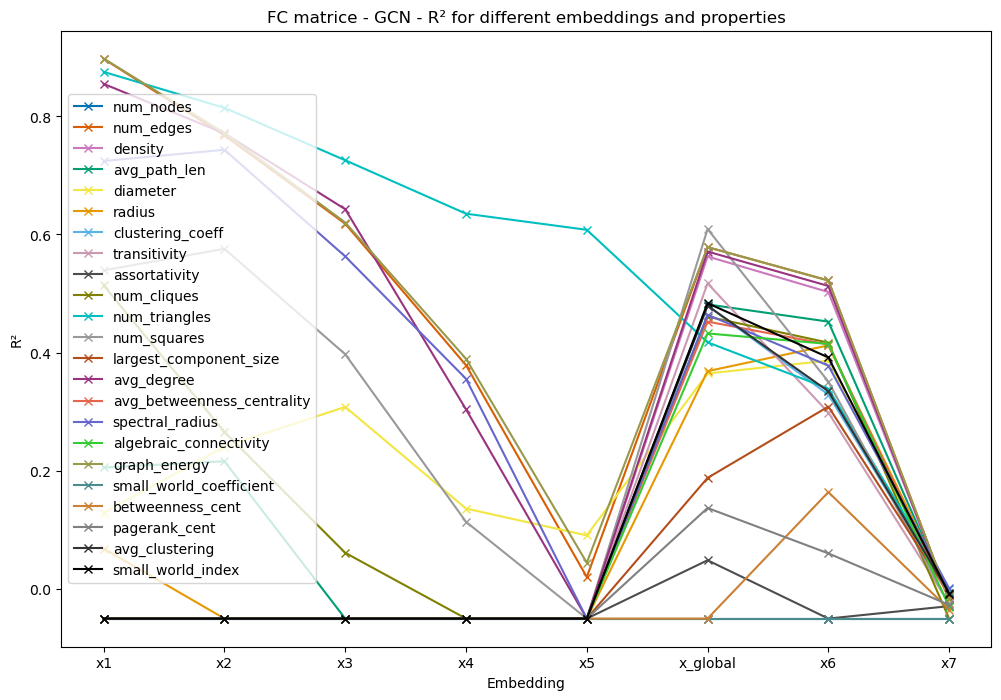

<Figure size 640x480 with 0 Axes>

In [24]:
#import plt
import matplotlib.pyplot as plt
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']
#make a color list for the properties names but with different colors
colors_long = [
    (0.0, 0.45, 0.70),  # Blue
    (0.85, 0.37, 0.01),  # Orange
    (0.8, 0.47, 0.74),   # Magenta
    (0.0, 0.62, 0.45),   # Green
    (0.95, 0.90, 0.25),  # Yellow
    (0.9, 0.6, 0.0),     # Brown
    (0.35, 0.7, 0.9),    # Sky Blue
    (0.8, 0.6, 0.7),     # Light Pink
    (0.3, 0.3, 0.3),     # Dark Gray
    (0.5, 0.5, 0.0),     # Olive
    (0.0, 0.75, 0.75),   # Cyan
    (0.6, 0.6, 0.6),     # Light Gray
    (0.7, 0.3, 0.1),     # Dark Orange
    (0.6, 0.2, 0.5),     # Purple
    (0.9, 0.4, 0.3),     # Salmon
    (0.4, 0.4, 0.8),     # Light Blue
    (0.2, 0.8, 0.2),     # Light Green
    (0.6, 0.6, 0.3),     # Mustard
    (0.3, 0.55, 0.55),    # Teal
    (0.8, 0.5, 0.2),     # Dark Salmon
    (0.5, 0.5, 0.5),     # Gray
    (0.2, 0.2, 0.2),     # Black-Gray
    (0.0, 0.0, 0.0)      # Black
]
plt.figure(figsize=(12, 8))

for i, property_names_long in enumerate(property_names_long):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_names_long)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_names_long, color=colors_long[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+"_"+MODEL+'_test_R2_plot_limited_cv_long_full_embedding.png', dpi=300, bbox_inches='tight')

In [34]:
#print the R2 values in order (bigger to smaller) for x_global

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']

embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']

#sort the R2 values for x_global
r2_values = []
for property_name in property_names_long:
    r2_values.append(results[('x_global', property_name)][3])

r2_values_sorted = sorted(r2_values, reverse=True)
print(r2_values_sorted)

#sort the property names
property_names_long_sorted = [x for _, x in sorted(zip(r2_values, property_names_long), reverse=True)]
print(property_names_long_sorted)

[0.6090954542160034, 0.5785549283027649, 0.5785547494888306, 0.5710922479629517, 0.5627355575561523, 0.5171620845794678, 0.48370879888534546, 0.481626033782959, 0.47943955659866333, 0.47933870553970337, 0.4641278386116028, 0.4609038829803467, 0.45253467559814453, 0.4325084686279297, 0.4175136089324951, 0.3686663508415222, 0.3647555112838745, 0.18807393312454224, 0.13714563846588135, 0.04869192838668823, -0.05669963359832764, -0.09409618377685547, -1.3222777843475342]
['num_squares', 'graph_energy', 'num_edges', 'avg_degree', 'density', 'transitivity', 'small_world_index', 'avg_path_len', 'avg_clustering', 'clustering_coeff', 'spectral_radius', 'num_cliques', 'avg_betweenness_centrality', 'algebraic_connectivity', 'num_triangles', 'radius', 'diameter', 'largest_component_size', 'pagerank_cent', 'assortativity', 'num_nodes', 'small_world_coefficient', 'betweenness_cent']


In [35]:
#same for x6

#sort the R2 values for x6
r2_values = []
for property_name in property_names_long:
    r2_values.append(results[('x6', property_name)][3])

r2_values_sorted = sorted(r2_values, reverse=True)
print(r2_values_sorted)

#sort the property names
property_names_long_sorted = [x for _, x in sorted(zip(r2_values, property_names_long), reverse=True)]
print(property_names_long_sorted)

[0.522092878818512, 0.522091269493103, 0.5128549337387085, 0.5025855898857117, 0.4524869918823242, 0.4169384837150574, 0.4147563576698303, 0.4137481451034546, 0.4122782349586487, 0.39186936616897583, 0.3865439295768738, 0.37806111574172974, 0.35091328620910645, 0.33920663595199585, 0.3346071243286133, 0.3290066123008728, 0.3087393045425415, 0.29865479469299316, 0.16403818130493164, 0.060342609882354736, -0.09877514839172363, -0.14251136779785156, -0.22295606136322021]
['graph_energy', 'num_edges', 'avg_degree', 'density', 'avg_path_len', 'num_cliques', 'algebraic_connectivity', 'avg_betweenness_centrality', 'radius', 'small_world_index', 'diameter', 'spectral_radius', 'num_squares', 'num_triangles', 'avg_clustering', 'clustering_coeff', 'largest_component_size', 'transitivity', 'betweenness_cent', 'pagerank_cent', 'num_nodes', 'small_world_coefficient', 'assortativity']


In [36]:
#same for x7

#sort the R2 values for x7
r2_values = []
for property_name in property_names_long:
    r2_values.append(results[('x7', property_name)][3])

r2_values_sorted = sorted(r2_values, reverse=True)
print(r2_values_sorted)

#sort the property names
property_names_long_sorted = [x for _, x in sorted(zip(r2_values, property_names_long), reverse=True)]
print(property_names_long_sorted)

[0.0011767745018005371, 1.1265277862548828e-05, -0.006779909133911133, -0.006829738616943359, -0.007808685302734375, -0.007820963859558105, -0.009294867515563965, -0.010425329208374023, -0.01376485824584961, -0.016520977020263672, -0.016980409622192383, -0.01721322536468506, -0.017390012741088867, -0.017391204833984375, -0.024333953857421875, -0.025952935218811035, -0.026882529258728027, -0.02892780303955078, -0.02993631362915039, -0.03466188907623291, -0.051340341567993164, -0.06316637992858887, -0.08530426025390625]
['spectral_radius', 'num_triangles', 'avg_clustering', 'clustering_coeff', 'small_world_index', 'radius', 'largest_component_size', 'diameter', 'avg_path_len', 'avg_betweenness_centrality', 'density', 'avg_degree', 'num_edges', 'graph_energy', 'transitivity', 'num_squares', 'pagerank_cent', 'assortativity', 'algebraic_connectivity', 'betweenness_cent', 'num_cliques', 'num_nodes', 'small_world_coefficient']


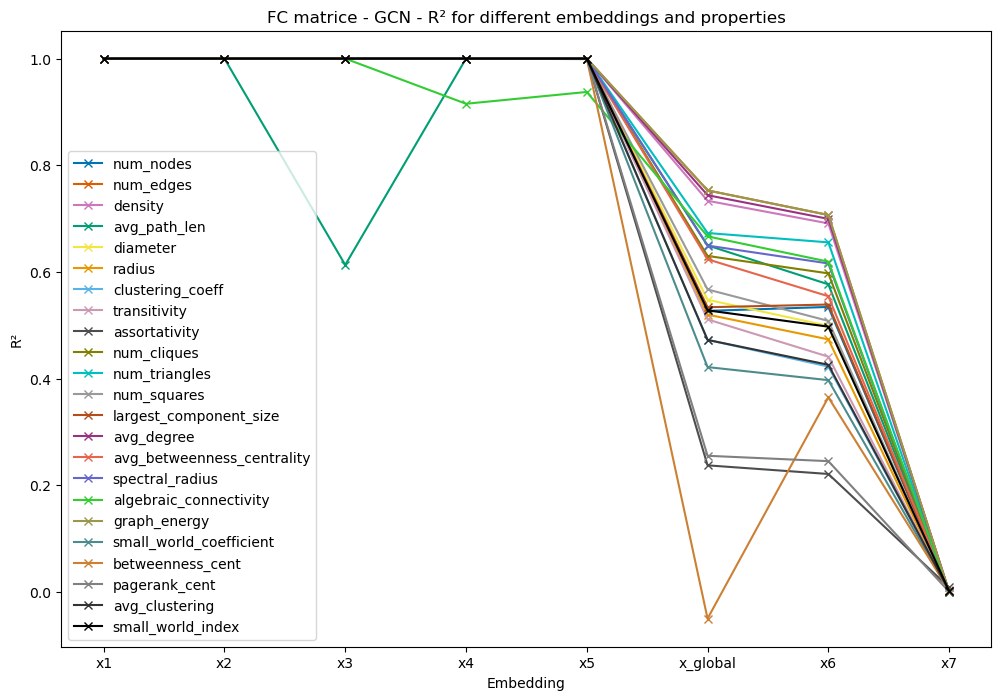

<Figure size 640x480 with 0 Axes>

In [25]:
plt.figure(figsize=(12, 8))
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']

for i, property_names_long in enumerate(property_names_long):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        train_r2 = results[(name_of_embedding, property_names_long)][2]
        if train_r2 < -0.05:  # Handle negative R² values
            train_r2 = -0.05
        x_points.append(j)
        y_points.append(train_r2)

    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_names_long, color=colors_long[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+"_"+MODEL+'_train_R2_plot_limited_cv_long_full_embedding.png', dpi=300, bbox_inches='tight')
    

# Comparison with a gnn train on random (the y are shuffled)

In [1]:
from Datasets.FC.create_dataset import read_dataset
dataset = read_dataset()
MODEL = "GCN_w_edge_weight"
DATASET = "FC_suffled"

from models.models_FC import GCN_framework_wo_edge_weight as framework # import the model


In [2]:
#shuffle the y values of the dataset
# import numpy as np
# import torch

# y = np.array([data.y for data in dataset])
# print(y)
# y = np.array(y, dtype=np.int64)  # Ensure y is a numeric array of type int64

# np.random.shuffle(y)

# #make y torch.int64, tensor([0]) instead of [0]
# y = torch.tensor(y, dtype=torch.int64)

# for i in range(len(dataset)):
#     dataset[i].y = y[i]

#check if the y values are shuffled
# y = np.array([data.y for data in dataset])
# print(y)

In [2]:
#save the dataset
# import pickle as pkl
# with open("Datasets/FC/"+DATASET+"_"+MODEL+".pkl", "wb") as f:
#     pkl.dump(dataset, f)

#load the dataset
import pickle as pkl
with open("Datasets/FC/"+DATASET+"_"+MODEL+".pkl", "rb") as f:
    dataset = pkl.load(f)

In [3]:
gnn = framework(dataset)

c:\Users\tomdu\miniconda3\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [5]:
# gnn.iterate()

In [6]:
#save the model 
# gnn.save_model(path="models/"+DATASET+"_"+MODEL+".pt")

In [4]:
#load the model
gnn.load_model(path="models/"+DATASET+"_"+MODEL+".pt", map_location='cpu')

In [5]:
gnn.evaluate()

Test Loss: 0.984, Train Acc: 0.494 Test Acc: 0.491


In [6]:
train_features, test_features = gnn.evaluate_with_features2()

In [ ]:
train_idx_list = gnn.train_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in train_idx_list]
train_properties_long = compute_graph_properties(selected_dataset)
test_idx_list = gnn.test_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in test_idx_list]
test_properties_long = compute_graph_properties(selected_dataset)

#save the properties in a file
with open("results/"+DATASET+"_"+MODEL+"_train_properties_long.pkl", "wb") as f:
    pkl.dump(train_properties_long, f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_long.pkl", "wb") as f:
    pkl.dump(test_properties_long, f)

In [7]:
import pickle as pkl
#save the properties in a file
# with open("results/"+DATASET+"_"+MODEL+"_train_properties_long.pkl", "wb") as f:
#     pkl.dump(train_properties_long, f)

# with open("results/"+DATASET+"_"+MODEL+"_test_properties_long.pkl", "wb") as f:
#     pkl.dump(test_properties_long, f)

#load the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties_long.pkl", "rb") as f:
    train_properties_long = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_long.pkl", "rb") as f:
    test_properties_long = pkl.load(f)

In [8]:
"""
The embeddings of GCN are like this:
return F.log_softmax(x7, dim=-1), (x1, x2, x3, x4, x5, x_global, x6, x7)
"""


import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
output_size = 1  # Predicting one property at a time
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Assume we have already evaluated to get features
#train_features, test_features = gnn.evaluate_with_features2()

# Extract x embeddings
train_x = np.array([feat[0] for feat in train_features])
test_x = np.array([feat[0] for feat in test_features])

# Extract 2, 3, 4, global, 5, 6, 7 embeddings
train_x2 = np.array([feat[1] for feat in train_features])
test_x2 = np.array([feat[1] for feat in test_features])

train_x3 = np.array([feat[2] for feat in train_features])
test_x3 = np.array([feat[2] for feat in test_features])

train_x4 = np.array([feat[3] for feat in train_features])
test_x4 = np.array([feat[3] for feat in test_features])

train_x5 = np.array([feat[4] for feat in train_features])
test_x5 = np.array([feat[4] for feat in test_features])

train_x_global = np.array([feat[5] for feat in train_features])
test_x_global = np.array([feat[5] for feat in test_features])

train_x6 = np.array([feat[6] for feat in train_features])
test_x6 = np.array([feat[6] for feat in test_features])

train_x7 = np.array([feat[7] for feat in train_features])
test_x7 = np.array([feat[7] for feat in test_features])

# Compute graph properties
# train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
# test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_x2 = torch.tensor(train_x2, dtype=torch.float32)
train_x3 = torch.tensor(train_x3, dtype=torch.float32)
train_x4 = torch.tensor(train_x4, dtype=torch.float32)
train_x5 = torch.tensor(train_x5, dtype=torch.float32)
train_x_global = torch.tensor(train_x_global, dtype=torch.float32)
train_x6 = torch.tensor(train_x6, dtype=torch.float32)
train_x7 = torch.tensor(train_x7, dtype=torch.float32)

test_x = torch.tensor(test_x, dtype=torch.float32)
test_x2 = torch.tensor(test_x2, dtype=torch.float32)
test_x3 = torch.tensor(test_x3, dtype=torch.float32)
test_x4 = torch.tensor(test_x4, dtype=torch.float32)
test_x5 = torch.tensor(test_x5, dtype=torch.float32)
test_x_global = torch.tensor(test_x_global, dtype=torch.float32)
test_x6 = torch.tensor(test_x6, dtype=torch.float32)
test_x7 = torch.tensor(test_x7, dtype=torch.float32)

# train_y = torch.tensor(train_properties, dtype=torch.float32)
# test_y = torch.tensor(test_properties, dtype=torch.float32)

# Train and evaluate a model for each graph property and each embedding
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x5, test_x5), (train_x_global, test_x_global), (train_x6, test_x6), (train_x7, test_x7)]
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']

In [ ]:
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
train_y_long = torch.tensor(train_properties_long, dtype=torch.float32)
test_y_long = torch.tensor(test_properties_long, dtype=torch.float32)
#create a dictionary where we will store the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    # Flatten the embeddings before determining the input size
    train_embedding_flat = train_embedding.view(train_embedding.size(0), -1)
    test_embedding_flat = test_embedding.view(test_embedding.size(0), -1)
    #print the shapes
    print(train_embedding_flat.shape)
    print(test_embedding_flat.shape)
    input_size = train_embedding_flat.shape[1]

    for i, property_name in enumerate(property_names_long):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 2000000  # Maximum number of epochs
        min_epochs = 1000  # Minimum number of epochs
        patience = 3000  # Number of epochs to wait for improvement
        tolerance = 1e-6  # Tolerance for considering the loss as stable

        best_loss = float('inf')
        no_improve_count = 0
        
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding_flat).squeeze()
            target = train_y_long[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Print every 1000 epochs
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

            # Check for early stopping, but only after minimum epochs
            if epoch >= min_epochs:
                if loss.item() < best_loss - tolerance:
                    best_loss = loss.item()
                    no_improve_count = 0
                else:
                    no_improve_count += 1

                if no_improve_count >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding_flat).squeeze().cpu().numpy()
            test_pred = model(test_embedding_flat).squeeze().cpu().numpy()

            train_target = train_y_long[:, i].cpu().numpy()
            test_target = test_y_long[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embedding = embeddings_names[ii]
            results[(name_of_embedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1


#save results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long_full_embedding.pkl", "wb") as f:
    pkl.dump(results, f)

/scratch-local/tpelletreaudur.7734772/ipykernel_4097216/225588825.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  train_y_long = torch.tensor(train_properties_long, dtype=torch.float32)
/scratch-local/tpelletreaudur.7734772/ipykernel_4097216/225588825.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  test_y_long = torch.tensor(test_properties_long, dtype=torch.float32)


torch.Size([1044, 14848])
torch.Size([55, 14848])
Epoch [1000/2000000], Property: num_nodes, Loss: 1.8647
Epoch [2000/2000000], Property: num_nodes, Loss: 0.0854
Epoch [3000/2000000], Property: num_nodes, Loss: 0.0019
Epoch [4000/2000000], Property: num_nodes, Loss: 0.0005
Epoch [5000/2000000], Property: num_nodes, Loss: 0.0005
Epoch [6000/2000000], Property: num_nodes, Loss: 0.0005
Epoch [7000/2000000], Property: num_nodes, Loss: 0.0005
Early stopping at epoch 7281
Embedding: torch.Size([1044, 116, 128])
Property: num_nodes
  Train MSE: 0.0005, Test MSE: 27.5947
  Train R²: 0.9998, Test R²: -30.3340
Epoch [1000/2000000], Property: num_edges, Loss: 13250.2549
Epoch [2000/2000000], Property: num_edges, Loss: 7183.0410
Epoch [3000/2000000], Property: num_edges, Loss: 3540.9373
Epoch [4000/2000000], Property: num_edges, Loss: 1460.7985
Epoch [5000/2000000], Property: num_edges, Loss: 443.8512
Epoch [6000/2000000], Property: num_edges, Loss: 82.5867
Epoch [7000/2000000], Property: num_edge

Epoch [1000/2000000], Property: spectral_radius, Loss: 0.0009
Epoch [2000/2000000], Property: spectral_radius, Loss: 0.0000
Epoch [3000/2000000], Property: spectral_radius, Loss: 0.0000
Epoch [4000/2000000], Property: spectral_radius, Loss: 0.0000
Early stopping at epoch 4863
Embedding: torch.Size([1044, 116, 128])
Property: spectral_radius
  Train MSE: 0.0000, Test MSE: 19.6926
  Train R²: 1.0000, Test R²: -0.8848
Epoch [1000/2000000], Property: algebraic_connectivity, Loss: 0.0001
Epoch [2000/2000000], Property: algebraic_connectivity, Loss: 0.0001
Epoch [3000/2000000], Property: algebraic_connectivity, Loss: 0.0001
Epoch [4000/2000000], Property: algebraic_connectivity, Loss: 0.0001
Early stopping at epoch 4001
Embedding: torch.Size([1044, 116, 128])
Property: algebraic_connectivity
  Train MSE: 0.0001, Test MSE: 0.3293
  Train R²: 0.9994, Test R²: -1.6189
Epoch [1000/2000000], Property: graph_energy, Loss: 71506.0156
Epoch [2000/2000000], Property: graph_energy, Loss: 50683.4141
Ep

Epoch [5000/2000000], Property: num_cliques, Loss: 0.2595
Epoch [6000/2000000], Property: num_cliques, Loss: 0.2535
Epoch [7000/2000000], Property: num_cliques, Loss: 0.2534
Epoch [8000/2000000], Property: num_cliques, Loss: 0.2534
Epoch [9000/2000000], Property: num_cliques, Loss: 0.2534
Epoch [10000/2000000], Property: num_cliques, Loss: 0.2575
Early stopping at epoch 10141
Embedding: torch.Size([1044, 116, 128])
Property: num_cliques
  Train MSE: 0.2534, Test MSE: 1136.3630
  Train R²: 0.9998, Test R²: -0.4810
Epoch [1000/2000000], Property: num_triangles, Loss: 487476.4688
Epoch [2000/2000000], Property: num_triangles, Loss: 380335.2188
Epoch [3000/2000000], Property: num_triangles, Loss: 288899.5625
Epoch [4000/2000000], Property: num_triangles, Loss: 209812.5625
Epoch [5000/2000000], Property: num_triangles, Loss: 143518.2812
Epoch [6000/2000000], Property: num_triangles, Loss: 90808.1328
Epoch [7000/2000000], Property: num_triangles, Loss: 51745.2695
Epoch [8000/2000000], Proper

In [9]:
#load results 
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long_full_embedding.pkl", "rb") as f:
    results = pkl.load(f)

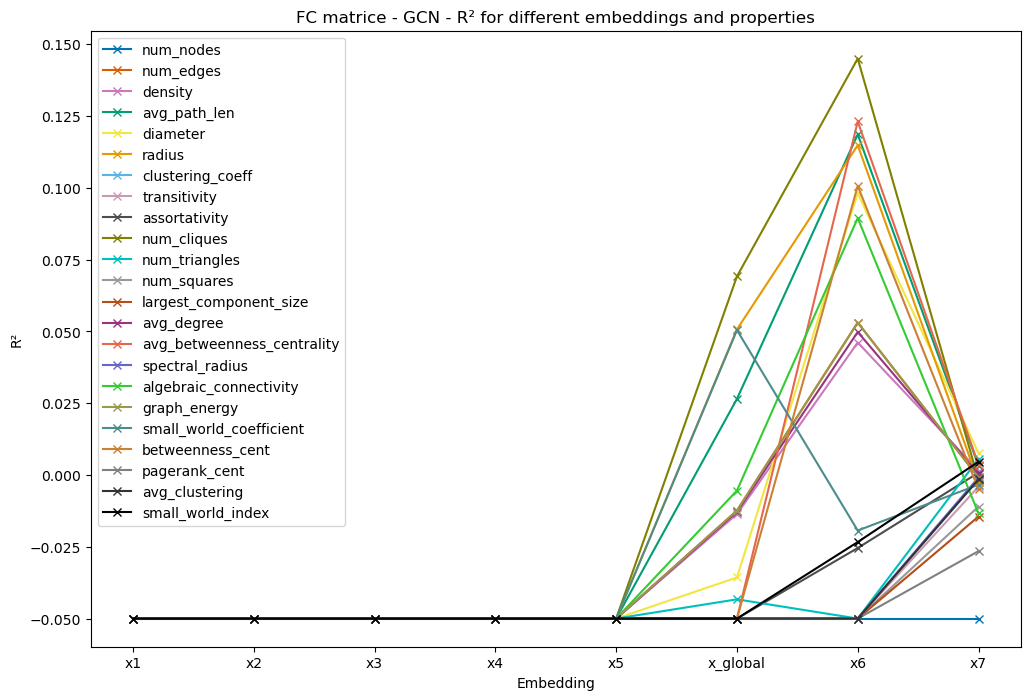

<Figure size 640x480 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt
colors_long = [
    (0.0, 0.45, 0.70),  # Blue
    (0.85, 0.37, 0.01),  # Orange
    (0.8, 0.47, 0.74),   # Magenta
    (0.0, 0.62, 0.45),   # Green
    (0.95, 0.90, 0.25),  # Yellow
    (0.9, 0.6, 0.0),     # Brown
    (0.35, 0.7, 0.9),    # Sky Blue
    (0.8, 0.6, 0.7),     # Light Pink
    (0.3, 0.3, 0.3),     # Dark Gray
    (0.5, 0.5, 0.0),     # Olive
    (0.0, 0.75, 0.75),   # Cyan
    (0.6, 0.6, 0.6),     # Light Gray
    (0.7, 0.3, 0.1),     # Dark Orange
    (0.6, 0.2, 0.5),     # Purple
    (0.9, 0.4, 0.3),     # Salmon
    (0.4, 0.4, 0.8),     # Light Blue
    (0.2, 0.8, 0.2),     # Light Green
    (0.6, 0.6, 0.3),     # Mustard
    (0.3, 0.55, 0.55),    # Teal
    (0.8, 0.5, 0.2),     # Dark Salmon
    (0.5, 0.5, 0.5),     # Gray
    (0.2, 0.2, 0.2),      # Black-Gray
    (0.0, 0.0, 0.0)      # Black
]

property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']

plt.figure(figsize=(12, 8))

for i, property_names_long in enumerate(property_names_long):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_names_long)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_names_long, color=colors_long[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+'_'+MODEL+'test_R2_plot_long_random_full_embedding.png')

In [11]:
#print the R2 values in order (bigger to smaller) for x_global

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']

embeddings_names = ['x', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']

#sort the R2 values for x_global
r2_values = []
for property_name in property_names_long:
    r2_values.append(results[('x_global', property_name)][3])

r2_values_sorted = sorted(r2_values, reverse=True)
print(r2_values_sorted)

#sort the property names
property_names_long_sorted = [x for _, x in sorted(zip(r2_values, property_names_long), reverse=True)]
print(property_names_long_sorted)

[0.06914067268371582, 0.050679147243499756, 0.05044150352478027, 0.026500582695007324, -0.005432486534118652, -0.012398242950439453, -0.012400627136230469, -0.012825608253479004, -0.013605594635009766, -0.03568887710571289, -0.04329860210418701, -0.05225646495819092, -0.08554315567016602, -0.10692238807678223, -0.12106728553771973, -0.13230538368225098, -0.13417291641235352, -0.14429616928100586, -0.14429998397827148, -0.1757577657699585, -0.1930246353149414, -0.24357819557189941, -4.383932113647461]
['num_cliques', 'radius', 'small_world_coefficient', 'avg_path_len', 'algebraic_connectivity', 'num_edges', 'graph_energy', 'avg_degree', 'density', 'diameter', 'num_triangles', 'betweenness_cent', 'assortativity', 'spectral_radius', 'small_world_index', 'pagerank_cent', 'num_squares', 'clustering_coeff', 'avg_clustering', 'transitivity', 'num_nodes', 'largest_component_size', 'avg_betweenness_centrality']


In [12]:
#same for x6
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']

#sort the R2 values for x6
r2_values = []
for property_name in property_names_long:
    r2_values.append(results[('x6', property_name)][3])

r2_values_sorted = sorted(r2_values, reverse=True)
print(r2_values_sorted)

#sort the property names
property_names_long_sorted = [x for _, x in sorted(zip(r2_values, property_names_long), reverse=True)]
print(property_names_long_sorted)

[0.14497721195220947, 0.12307411432266235, 0.11857771873474121, 0.1148032546043396, 0.10062903165817261, 0.09815621376037598, 0.08943510055541992, 0.05306369066238403, 0.053063273429870605, 0.049779415130615234, 0.04612255096435547, -0.0193406343460083, -0.023358702659606934, -0.025427937507629395, -0.058141112327575684, -0.0838860273361206, -0.08689224720001221, -0.09310543537139893, -0.14667737483978271, -0.16109204292297363, -0.16226434707641602, -0.16324758529663086, -0.22269487380981445]
['num_cliques', 'avg_betweenness_centrality', 'avg_path_len', 'radius', 'betweenness_cent', 'diameter', 'algebraic_connectivity', 'graph_energy', 'num_edges', 'avg_degree', 'density', 'small_world_coefficient', 'small_world_index', 'assortativity', 'num_triangles', 'avg_clustering', 'clustering_coeff', 'spectral_radius', 'num_squares', 'pagerank_cent', 'transitivity', 'num_nodes', 'largest_component_size']


In [13]:
#same for x7

#sort the R2 values for x7
r2_values = []
for property_name in property_names_long:
    r2_values.append(results[('x7', property_name)][3])

r2_values_sorted = sorted(r2_values, reverse=True)
print(r2_values_sorted)

#sort the property names
property_names_long_sorted = [x for _, x in sorted(zip(r2_values, property_names_long), reverse=True)]
print(property_names_long_sorted)

[0.007584691047668457, 0.005602478981018066, 0.004599869251251221, 0.003593623638153076, 0.003201425075531006, 0.0015357136726379395, 0.0008099675178527832, 0.00029474496841430664, -0.0008599758148193359, -0.0008884668350219727, -0.000888824462890625, -0.001524209976196289, -0.0015250444412231445, -0.0016846656799316406, -0.00238645076751709, -0.0033818483352661133, -0.0040656328201293945, -0.00501251220703125, -0.010980844497680664, -0.0133589506149292, -0.014475226402282715, -0.026517033576965332, -0.06092226505279541]
['diameter', 'num_triangles', 'small_world_index', 'avg_betweenness_centrality', 'avg_path_len', 'density', 'assortativity', 'avg_degree', 'spectral_radius', 'num_edges', 'graph_energy', 'avg_clustering', 'clustering_coeff', 'num_cliques', 'radius', 'small_world_coefficient', 'transitivity', 'betweenness_cent', 'num_squares', 'algebraic_connectivity', 'largest_component_size', 'pagerank_cent', 'num_nodes']


# Node embedding probing

/!\ Try to not forget that we need to change the batch_size to 1 if we want to probe for node properties as we need the forward pass to be made 1 graph by 1 graph at a time. 

In [1]:
from Datasets.FC.create_dataset import read_dataset
dataset = read_dataset()
import torch
torch.manual_seed(37)
MODEL = "GCN_wo_edge_weight"
DATASET = "FC"
from models.models_FC import GCN_framework_wo_edge_weight as framework # import the model
gnn = framework(dataset)
#load the model
gnn.load_model(path="models/"+DATASET+"_"+MODEL+"server.pt")
gnn.evaluate()

c:\Users\tomdu\miniconda3\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Test Loss: 0.728, Train Acc: 1.000 Test Acc: 0.564


## Visualisation

In [2]:
import networkx as nx

# Define function to compute node-level properties
def compute_node_properties(data):
    properties = []
    for graph_data in data:
        try:
            # Convert edge index to NetworkX graph
            G = nx.from_edgelist(graph_data.edge_index.t().tolist())
            
            # Add all nodes to the graph to handle disconnected nodes
            all_nodes = range(len(graph_data.x))
            connected_nodes = set(G.nodes())
            disconnected_nodes = set(all_nodes) - connected_nodes
            
            # Compute node-level properties for connected nodes
            node_degrees = dict(G.degree())
            clustering_coeffs = nx.clustering(G)
            betweenness_centralities = nx.betweenness_centrality(G)
            eigenvector_centralities = nx.eigenvector_centrality(G, max_iter=10000)
            
            # Initialize properties with zeros for all nodes
            node_degrees_full = [0] * len(graph_data.x)
            clustering_coeffs_full = [0] * len(graph_data.x)
            betweenness_centralities_full = [0] * len(graph_data.x)
            eigenvector_centralities_full = [0] * len(graph_data.x)
            
            # Assign computed properties to the respective nodes
            for node in connected_nodes:
                node_degrees_full[node] = node_degrees[node]
                clustering_coeffs_full[node] = clustering_coeffs[node]
                betweenness_centralities_full[node] = betweenness_centralities[node]
                eigenvector_centralities_full[node] = eigenvector_centralities[node]

            # Append properties as a tuple
            properties.append((node_degrees_full, clustering_coeffs_full, betweenness_centralities_full, eigenvector_centralities_full))
        except Exception as e:
            print(f"Error processing graph: {e}")
            properties.append(([], [], [], []))  # Append empty properties in case of error
    return properties

# Ensure gnn.train_idx and gnn.test_idx are lists of integers
train_idx = gnn.train_idx.tolist() if isinstance(gnn.train_idx, torch.Tensor) else gnn.train_idx
test_idx = gnn.test_idx.tolist() if isinstance(gnn.test_idx, torch.Tensor) else gnn.test_idx

# Compute node-level properties for train and test sets
train_node_properties = compute_node_properties([gnn.dataset[i] for i in train_idx])
test_node_properties = compute_node_properties([gnn.dataset[i] for i in test_idx])

# train_node_properties is a list of tuples, where each tuple contains 4 lists,
# each list contains the node-level property for each node in the graph

In [ ]:
train_node_properties

In [22]:
train_idx[0]

217

In [23]:
len(train_node_properties), len(test_node_properties)

(1044, 55)

In [24]:
# Check the length of the first three betweenness centralities of the three first graphs in the train set
[len(train_node_properties[i][2]) for i in range(15)]

[116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116]

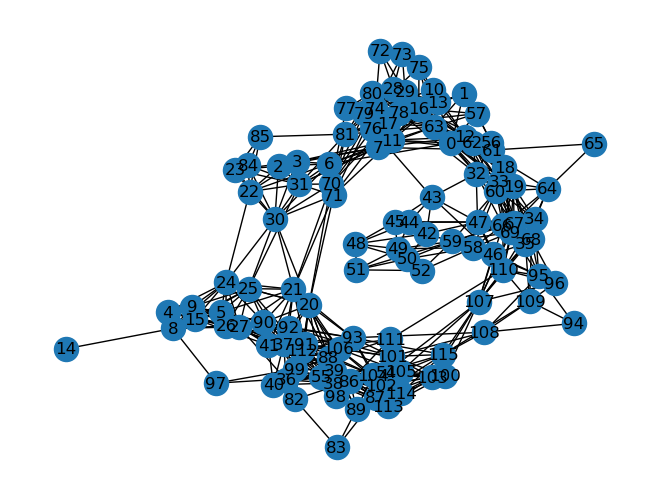

In [7]:
import networkx as nx
# Ensure gnn.test_idx is a list of integers
test_idx = gnn.test_idx.tolist() if isinstance(gnn.test_idx, torch.Tensor) else gnn.test_idx

# Visualize the first graph of the test set to see if the properties are correct
G = nx.from_edgelist(gnn.dataset[test_idx[1]].edge_index.t().tolist())
nx.draw(G, with_labels=True)


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\tomdu\AppData\Local\Temp\ipykernel_27092\707441326.py", line 7, in <module>
    nx.draw(G, with_labels=True, node_size=[v * 10000 for v in betweenness_centrality], node_color=node_degrees, cmap='viridis')
  File "c:\Users\tomdu\miniconda3\lib\site-packages\networkx\drawing\nx_pylab.py", line 121, in draw
    draw_networkx(G, pos=pos, ax=ax, **kwds)
  File "c:\Users\tomdu\miniconda3\lib\site-packages\networkx\drawing\nx_pylab.py", line 303, in draw_networkx
    draw_networkx_nodes(G, pos, **node_kwds)
  File "c:\Users\tomdu\miniconda3\lib\site-packages\networkx\drawing\nx_pylab.py", line 433, in draw_networkx_nodes
    node_collection = ax.scatter(
  File "c:\Users\tomdu\miniconda3\lib\site-packages\matplotlib\__init__.py", line 1414, in inner
    return func(ax, *map(saniti

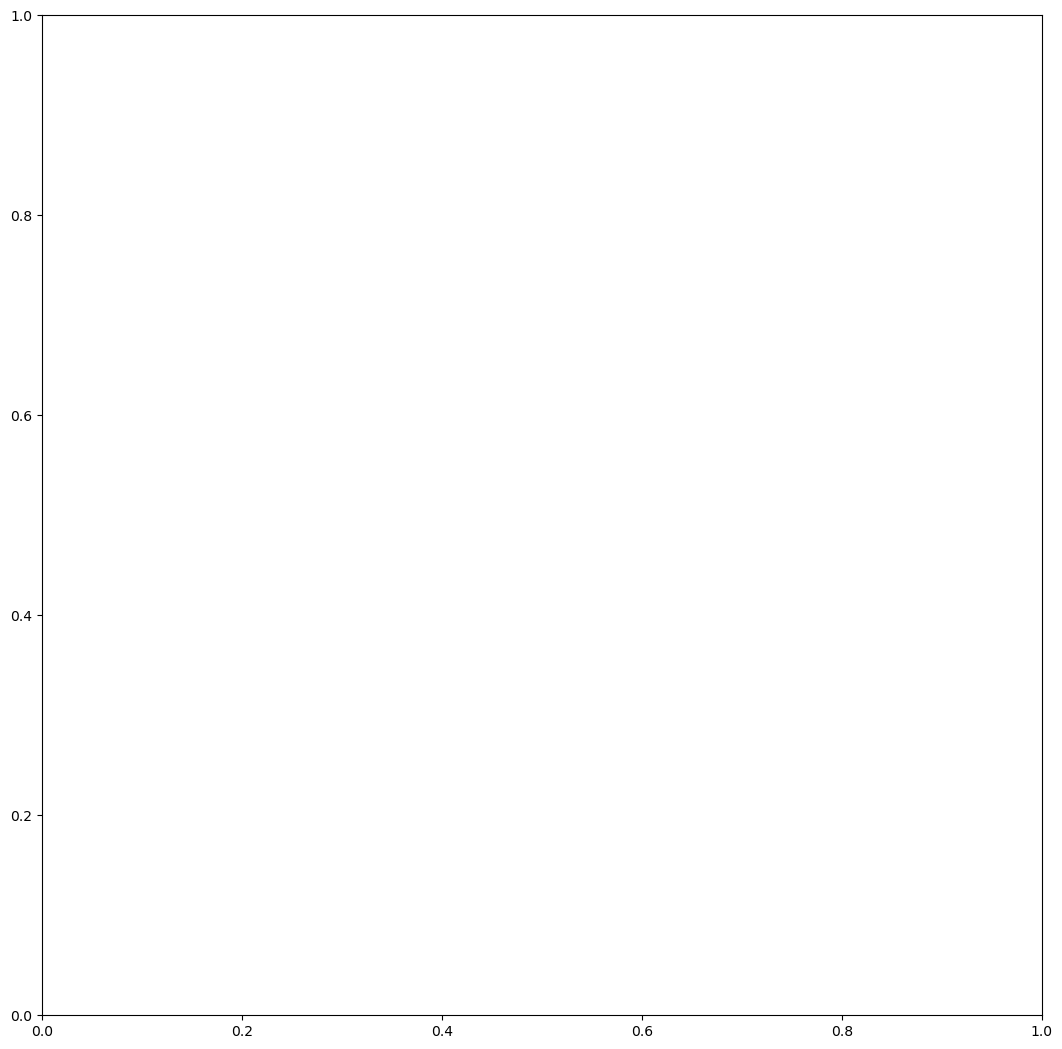

In [8]:
import matplotlib.pyplot as plt
#represent the properties of betweenness centrality on the graph by chaging the size of the nodes
betweenness_centrality = test_node_properties[0][2]
node_degrees = test_node_properties[0][0]

plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_size=[v * 10000 for v in betweenness_centrality], node_color=node_degrees, cmap='viridis')
plt.show()


In [ ]:
#same for eigenvector centrality
eigenvector_centralities = test_node_properties[0][3]

plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_size=[v * 10000 for v in eigenvector_centralities], node_color=node_degrees, cmap='viridis')
plt.show()

In [ ]:
#same for local clustering coefficients
Local_clustering_coefficients = test_node_properties[0][4]

plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_size=[v * 1000 for v in Local_clustering_coefficients], node_color=node_degrees, cmap='viridis')
plt.show()

We see that for each graph, the length of the betweenness centralities, and in general the length of properties, are equal to the number of nodes in the graph and thus
is equal to the length of the x matrix in the features. 

## Node Properties 

In [6]:
import networkx as nx
import torch

def compute_node_properties(data, indices):
    properties = []
    for idx in indices:
        graph_data = data[idx]
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        
        # Add all nodes to the graph to handle disconnected nodes
        all_nodes = set(range(len(graph_data.x)))
        connected_nodes = set(G.nodes())
        disconnected_nodes = all_nodes - connected_nodes
        
        # Calculate node properties using NetworkX for connected nodes
        degree = dict(G.degree())
        clustering = nx.clustering(G)
        betweenness = nx.betweenness_centrality(G)
        closeness = nx.closeness_centrality(G)
        eigenvector = nx.eigenvector_centrality(G, max_iter=10000)
        pagerank = nx.pagerank(G)

        # Initialize properties with zeros for all nodes
        node_properties = [{'degree': 0, 'clustering': 0, 'betweenness': 0, 'closeness': 0, 'eigenvector': 0, 'pagerank': 0} for _ in all_nodes]
        
        # Store properties for each connected node in the graph
        for node in connected_nodes:
            node_properties[node] = {
                'degree': degree[node],
                'clustering': clustering[node],
                'betweenness': betweenness[node],
                'closeness': closeness[node],
                'eigenvector': eigenvector[node],
                'pagerank': pagerank[node]
            }

        #if there a disconnected nodes : print 
        # if disconnected_nodes:
        #     print(f"Graph {idx}: Disconnected nodes: {disconnected_nodes}")
        #     print(node_properties)

        properties.append(node_properties)
    return properties

# Ensure gnn.train_idx and gnn.test_idx are lists of integers
train_idx = gnn.train_idx.tolist() if isinstance(gnn.train_idx, torch.Tensor) else gnn.train_idx
test_idx = gnn.test_idx.tolist() if isinstance(gnn.test_idx, torch.Tensor) else gnn.test_idx

# Compute node-level properties for train and test sets
train_node_properties = compute_node_properties(gnn.dataset, train_idx)
test_node_properties = compute_node_properties(gnn.dataset, test_idx)


## Features

In [30]:
train_features, test_features = gnn.evaluate_with_features2(return_node_embeddings=True)

len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.

len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.

len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.

len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.

len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.

len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.

len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.

len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.

len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.

len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.

len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.

len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.

len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.

len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.

len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.

train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Siz

len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.

len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.

len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.

len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.

len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.

len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.

In [31]:
len(train_features), len(test_features)

(1044, 55)

In [32]:
# Check the shape of the first graph's features
first_graph_features = train_features[1]
for i, feature in enumerate(first_graph_features):
    print(f"Feature {i+1} shape:", feature.shape)

Feature 1 shape: (116, 128)
Feature 2 shape: (116, 128)
Feature 3 shape: (116, 128)
Feature 4 shape: (116, 128)
Feature 5 shape: (116, 128)


In [33]:
train_features[1][0][115]

array([-0.37685958,  1.6929059 ,  1.7549721 , -0.59884256, -0.7069929 ,
       -0.64360166, -0.597654  , -0.58719116, -0.6589397 , -0.58917546,
       -0.6371779 ,  0.7570746 , -0.678448  , -0.57999843,  0.995853  ,
        0.78517485, -0.7277082 ,  2.59916   , -0.6501185 , -0.6727714 ,
        0.88018125,  3.412128  , -0.62779766, -0.6337086 , -0.687071  ,
        0.9279617 ,  1.7032542 , -0.6746877 , -0.1740045 , -0.6686538 ,
       -0.65484655, -0.6692905 , -0.67351073, -0.65264136,  0.6912534 ,
        0.07277143, -0.69103795, -0.6376403 , -0.5185264 , -0.69764876,
       -0.6681054 , -0.7185582 , -0.71772814,  0.5283297 , -0.73103005,
        0.28918484, -0.66227067, -0.6802141 , -0.6193606 , -0.67815536,
       -0.60691845,  1.8839593 , -0.5943558 , -0.02621274, -0.71328527,
       -0.68886244, -0.6890107 , -0.6547946 ,  0.6078464 , -0.701213  ,
        1.2887503 ,  2.1272626 , -0.58606315,  2.8298755 , -0.18379903,
       -0.5403074 , -0.76094735, -0.32233354,  0.40016913, -0.10

In [34]:
print(len(train_features))
print(len(train_features[0]))
print(train_features[0][0].shape)

1044
5
(116, 128)


In [35]:
print(len(train_node_properties))
print(len(train_node_properties[0]))
print(train_node_properties[0][0])

1044
116
{'degree': 9, 'clustering': 0.6666666666666666, 'betweenness': 0.0073517232342515905, 'closeness': 0.34023668639053256, 'eigenvector': 0.0012984180038352537, 'pagerank': 0.007510481485631736}


## Linear classifier

**Probe**

Example data structure for multiple graphs

train_features: List of graphs, each with multiple layers of features

```plaintext
train_features = [
    [np.array([...]), np.array([...]), ...],  # Graph 1: features for each layer
    [np.array([...]), np.array([...]), ...],  # Graph 2: features for each layer
    ...
]
```
train_node_properties: List of graphs, each with a list of node properties

```plaintext
train_node_properties = [
    [{'degree': ..., 'clustering': ..., ...}, {'degree': ..., ...}, ...],  # Graph 1: properties for each node
    [{'degree': ..., 'clustering': ..., ...}, {'degree': ..., ...}, ...],  # Graph 2: properties for each node
    ...
]
```
test_features and test_node_properties would be similarly structured for the test set

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

class LinearModel(nn.Module):
    def __init__(self, input_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

In [37]:
def train_probe_for_layer(features, property_values, test_features, test_property_values, num_epochs=10000, learning_rate=0.01):
    # Convert features and property values to PyTorch tensors if they are NumPy arrays
    if isinstance(features, np.ndarray):
        features = torch.tensor(features, dtype=torch.float32)
    if isinstance(property_values, np.ndarray):
        property_values = torch.tensor(property_values, dtype=torch.float32)

    if isinstance(test_features, np.ndarray):
        test_features = torch.tensor(test_features, dtype=torch.float32)
    if isinstance(test_property_values, np.ndarray):
        test_property_values = torch.tensor(test_property_values, dtype=torch.float32)

    print(f"Training on features with shape: {features.shape} for property values shape: {property_values.shape}")

    model = LinearModel(features.shape[1])  # Features should be 2D: (num_nodes, feature_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(features).squeeze()  # Remove single-dimensional entries
        loss = criterion(output, property_values)
        loss.backward()
        optimizer.step()

    # Evaluate on test data
    model.eval()
    with torch.no_grad():
        pred = model(test_features).squeeze()
        mse = criterion(pred, test_property_values).item()
        # Flatten the tensors for proper use of r2_score
        r2 = r2_score(test_property_values.cpu().numpy(), pred.cpu().numpy())

    return mse, r2

Where inspiring from the techniques developped in AIFB probing for one graph : to handle multiple graphs, we have a couple of options:

### Option 1: Train a Separate Classifier for Each Graph

This approach involves training a separate probe (classifier) for each graph independently. This means that for each graph, you would train a different probe for each property at each layer. This approach assumes that each graph might have a different structure and properties that are best modeled independently.

**Code :**

We would modify the `evaluate_layer_probes` function from the AIFB_probing_GCN to loop over the graphs and train separate models for each.

This will produce separate R² scores for each graph, layer, and property.

In [ ]:
def evaluate_layer_probes_per_graph(train_features_list, test_features_list, train_properties_list, test_properties_list):
    results = []

    num_test_graphs = len(test_features_list)  # Number of graphs in the test set

    # Iterate over the number of graphs in the training set
    for graph_idx in range(len(train_features_list)):
        train_features = train_features_list[graph_idx]
        train_properties = train_properties_list[graph_idx]

        # Use modulo to cycle through the test graphs
        test_idx = graph_idx % num_test_graphs
        test_features = test_features_list[test_idx]
        test_properties = test_properties_list[test_idx]

        num_layers = len(train_features)

        for layer_idx in range(num_layers):
            layer_train_features = train_features[layer_idx]
            layer_test_features = test_features[layer_idx]

            # Stack node features into a single matrix for each layer
            train_feature_matrix = np.vstack(layer_train_features)  # Shape: (num_nodes, feature_size)
            test_feature_matrix = np.vstack(layer_test_features)

            # Print the number of nodes to check for inconsistencies
            print(f"Graph {graph_idx}, Layer {layer_idx}: Train nodes = {train_feature_matrix.shape[0]}, Test nodes = {test_feature_matrix.shape[0]}")
            print(f"Graph {graph_idx}, Layer {layer_idx}: Train properties = {len(train_properties)}, Test properties = {len(test_properties)}")

            # Train and evaluate probe for each property
            for property_name in train_properties[0].keys():  # Assuming all nodes have the same properties
                train_property_values = np.array([node[property_name] for node in train_properties])
                test_property_values = np.array([node[property_name] for node in test_properties])

                mse, r2 = train_probe_for_layer(train_feature_matrix, train_property_values, test_feature_matrix, test_property_values)
                
                results.append({
                    'graph': graph_idx,
                    'layer': layer_idx,
                    'property': property_name,
                    'mse': mse,
                    'r2': r2
                })

    return results


In [ ]:
# Assuming train_features, test_features, train_properties, test_properties are already defined
results_per_graph = evaluate_layer_probes_per_graph(train_features, test_features, train_node_properties, test_node_properties)

In [ ]:

def plot_results_per_graph(results):
    layers = sorted(set(result['layer'] for result in results))
    properties = sorted(set(result['property'] for result in results))
    graphs = sorted(set(result['graph'] for result in results))
    
    plt.figure(figsize=(12, 6))  # Increase the figure size for better readability
    
    for property_name in properties:
        plt.figure(figsize=(12, 6))
        for graph_idx in graphs:
            r2_scores = []
            for layer in layers:
                layer_results = [r for r in results if r['layer'] == layer and r['property'] == property_name and r['graph'] == graph_idx]
                # Calculate mean R² score for the layer
                mean_r2 = np.mean([r['r2'] for r in layer_results])
                # Set any R² value below -0.05 to -0.05
                if mean_r2 < -0.05:
                    mean_r2 = -0.05
                r2_scores.append(mean_r2)
            
            # Plot the R² scores with crosses and lines, one line per graph
            plt.plot(layers, r2_scores, marker='x', linestyle='-', label=f'Graph {graph_idx}')
        
        plt.title(f'R² Scores Across Layers for Property: {property_name}')
        plt.xlabel('Layer')
        plt.ylabel('R² Score')
        plt.legend()
        plt.grid(True)  # Add grid for better visibility of points and lines
        plt.show()



In [ ]:
plot_results_per_graph(results_per_graph)


### Option 2: Train a Single Classifier Across All Graphs

This approach involves combining data from all graphs to train a single probe for each property across the graphs. This assumes that the properties across different graphs share some common structure that can be captured by a single model. We modify the `evaluate_layer_probes` function to aggregate features and properties across all graphs before training.

This approach results in a single probe being trained for each property at each layer, but the probe is trained on data aggregated from all graphs.

In [38]:
def evaluate_layer_probes_across_graphs(train_features_list, test_features_list, train_properties_list, test_properties_list):
    num_layers = len(train_features_list[0])  # Assuming all graphs have the same number of layers
    results = []

    num_test_graphs = len(test_features_list)  # Number of graphs in the test set

    for layer_idx in range(num_layers):
        combined_train_features = []
        combined_test_features = []
        combined_train_properties = []
        combined_test_properties = []

        # Aggregate features and properties across all graphs
        for graph_idx in range(len(train_features_list)):
            combined_train_features.append(np.vstack(train_features_list[graph_idx][layer_idx]))

            # Use modulo to cycle through the test graphs
            test_idx = graph_idx % num_test_graphs
            combined_test_features.append(np.vstack(test_features_list[test_idx][layer_idx]))

            combined_train_properties.extend(train_properties_list[graph_idx])
            combined_test_properties.extend(test_properties_list[test_idx])

        combined_train_features = np.vstack(combined_train_features)  # Combine features across graphs
        combined_test_features = np.vstack(combined_test_features)

        # Train and evaluate probe for each property across all graphs
        for property_name in combined_train_properties[0].keys():  # Assuming all nodes have the same properties
            train_property_values = np.array([node[property_name] for node in combined_train_properties])
            test_property_values = np.array([node[property_name] for node in combined_test_properties])

            mse, r2 = train_probe_for_layer(combined_train_features, train_property_values, combined_test_features, test_property_values)
            
            results.append({
                'layer': layer_idx,
                'property': property_name,
                'mse': mse,
                'r2': r2
            })

    return results


In [39]:
results_across_graphs = evaluate_layer_probes_across_graphs(train_features, test_features, train_node_properties, test_node_properties)

#save the results
with open("results/"+DATASET+"_"+MODEL+"_node_results_across_graphs.pkl", "wb") as f:
    pkl.dump(results_across_graphs, f)

Training on features with shape: torch.Size([121104, 128]) for property values shape: torch.Size([121104])
Training on features with shape: torch.Size([121104, 128]) for property values shape: torch.Size([121104])
Training on features with shape: torch.Size([121104, 128]) for property values shape: torch.Size([121104])
Training on features with shape: torch.Size([121104, 128]) for property values shape: torch.Size([121104])
Training on features with shape: torch.Size([121104, 128]) for property values shape: torch.Size([121104])
Training on features with shape: torch.Size([121104, 128]) for property values shape: torch.Size([121104])
Training on features with shape: torch.Size([121104, 128]) for property values shape: torch.Size([121104])
Training on features with shape: torch.Size([121104, 128]) for property values shape: torch.Size([121104])
Training on features with shape: torch.Size([121104, 128]) for property values shape: torch.Size([121104])
Training on features with shape: torc

In [40]:
#load the results
with open("results/"+DATASET+"_"+MODEL+"_node_results_across_graphs.pkl", "rb") as f:
    results_across_graphs = pkl.load(f)

### Choosing Between Options:

- If our graphs are very similar in nature and you expect the relationships between node embeddings and their properties to be consistent across all graphs, **Option 2** (Single Classifier Across Graphs) will be the better choice.
  
- If our graphs are diverse, or we expect the relationships to vary significantly between graphs, *Option 1* (Separate Classifiers) might be more appropriate.

We experiment with both approaches and compare the performance to see which one gives us the best results : we decided to keep option 2

### Results:

- *Layers and Properties*: The function iterate over the layers and properties to aggregate and visualize the R² scores.
  
- *Mean R² Calculation*: The mean R² scores are calculated for each layer and property. If any R² value is below `-0.05`, it is set to `-0.05` to prevent extreme values from skewing the visualization.

- *Plotting*:
  - *Option 1 (`plot_results_per_graph`)*: Plots a separate line for each graph, allowing you to see how the R² scores vary across layers and graphs.
  - *Option 2 (`plot_results_across_graphs`)*: Plots a single line for each property, aggregating the results across all graphs. This provides a high-level view of how each property behaves across layers when considering all graphs together.
  
We decided to keep option 2 as it makes more sense. This function is designed to visualize the results from the `evaluate_layer_probes_across_graphs` function. It will plot the R² scores for each property across layers, combining the results from all graphs into single lines.


In [41]:
import pickle as pkl
import matplotlib.pyplot as plt
def plot_results_across_graphs(results):
    layers = sorted(set(result['layer'] for result in results))
    properties = sorted(set(result['property'] for result in results))
    
    plt.figure(figsize=(12, 6))  # Increase the figure size for better readability
    
    for property_name in properties:
        r2_scores = []
        for layer in layers:
            layer_results = [r for r in results if r['layer'] == layer and r['property'] == property_name]
            # Calculate mean R² score for the layer
            mean_r2 = np.mean([r['r2'] for r in layer_results])
            # Set any R² value below -0.05 to -0.05
            if mean_r2 < -0.05:
                mean_r2 = -0.05
            r2_scores.append(mean_r2)
        
        # Plot the R² scores with crosses and lines, one line per property across all graphs
        plt.plot(layers, r2_scores, marker='x', linestyle='-', label=property_name)

    plt.title('R² Scores Across Layers for Different Properties (Aggregated Across Graphs)')
    plt.xticks(layers, [f'Layer {i+1}' for i in layers])  # Set the x-axis labels to layer numbers
    plt.xlabel('Layer')
    plt.ylabel('R² Score')
    plt.legend()
    plt.grid(True)  # Add grid for better visibility of points and lines
    plt.show()

    # Save the plot
    with open("results/"+DATASET+"_"+MODEL+"_node_results_across_graphs.pkl", "wb") as f:
        pkl.dump(results, f)

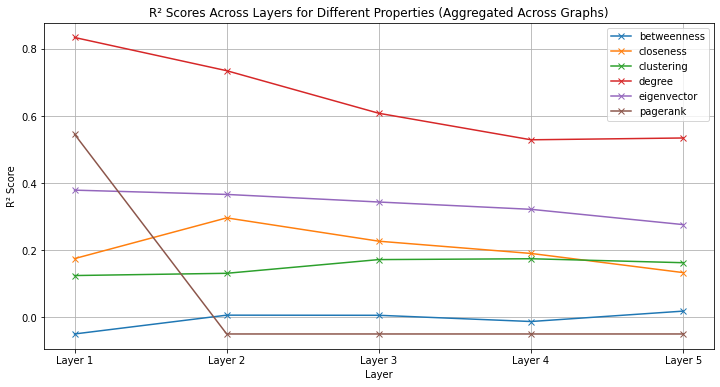

In [42]:
# Plot the results across all graphs
plot_results_across_graphs(results_across_graphs)